# Joint Intent Detection and Slot Filling

We are going to load pre-trained BERT model and fine-tune it for an intent detection.

# Setup

In [81]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
print(os.environ["CUDA_VISIBLE_DEVICES"])

0


In [82]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name())

True
1
NVIDIA GeForce RTX 3090


In [83]:
device = 'cuda'

In [1]:
import pandas as pd

# Load Dataset

## Intents With Slot

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Project/dataset

/content/drive/My Drive/Project/dataset


In [ ]:
df_with_slots = pd.read_excel(f"/content/drive/My Drive/Project/dataset/data_final.xlsx", usecols=['text','slots','intent','pattern_id'])
df_with_slots

,pattern_id,text,slots,intent
0,1,از تو چه پنهون دلم خیلی گرفته. برام دعای جوشن کبیر رو میتونی بخونی آروم بگیرم؟,o o o o o o o o o b-prayer_name i-prayer_name o o o o o,adie
1,2,خیلی ها رو دیدم که با دعای مکارم الاخلاق حاجت روا شدن. میای امتحانش کنیم؟,o o o o o o o b-prayer_name i-prayer_name o o o o o o,adie
2,3,دعایی که برای مشکلات و دشواری ها توصیه شده دعای حرز حضرت زهرا اس. برام بفرستش بخونمش,o o o o o o o o o o b-prayer_name i-prayer_name i-prayer_name o o o o,adie
3,4,خیلی مشکلات دارم تو زندگیم دعایی که برای رفع مشکلات توصیه شده رو بفرستش برام,o o o o o o o o o o o o o o o,adie
4,5,یکی امروز بهم گفت که دعای حدیث کسا خیلی کار راه اندازه. داریش برام بفرستیش؟,o o o o o o b-prayer_name i-prayer_name o o o o o o o,adie
...,...,...,...,...
24996,10084,برای یه سفر کاری باید پولامو چنج کنم به یورو. هر ریال ایران چند یورو است؟,o o o o o o o o o b-dest_currency o b-currency i-currency o b-dest_currency o,convert_currency
24997,10085,لطفاً غذایی را با لوبیا قرمز بمن پیشنهاد بده که در برای خانواده درست کنم,o o o o b-ingredient i-ingredient o o o o o o o o o,ask_what_to_cook
24998,10086,چه غذایی را پیشنهاد می‌دهید که با پنیر چدار بتوانم بپزم بات سرآشپز من,o o o o o o o b-ingredient i-ingredient o o o o o,ask_what_to_cook
24999,10087,تو که آشپز ماهری هستی یه غذا بگو بپزم که با لوبیا سبز بتونم درست کنم,o o o o o o o o o o o b-ingredient i-ingredient o o o,ask_what_to_cook


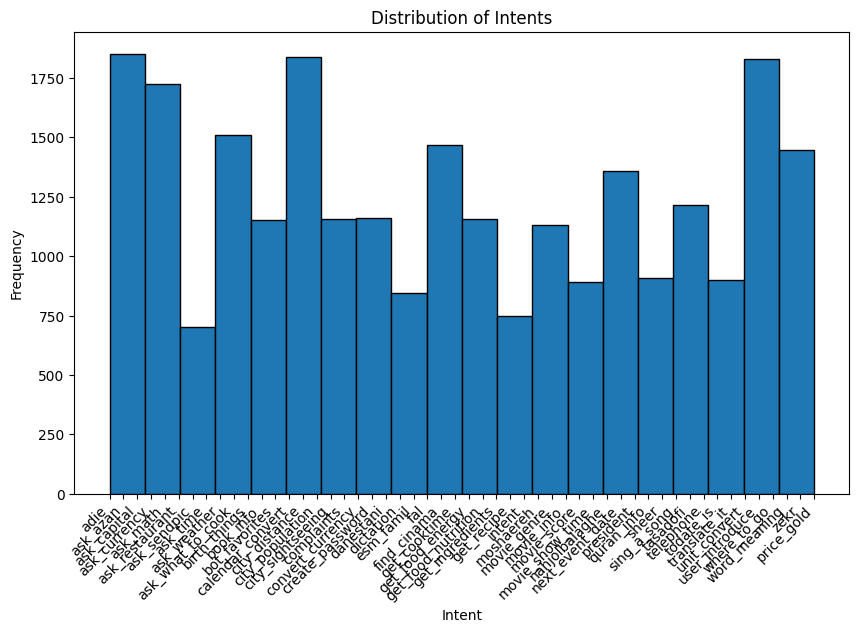

In [ ]:
# @title Distribution of Intents

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df_with_slots['intent'], bins=20, edgecolor='black')
plt.xlabel('Intent')
plt.ylabel('Frequency')
plt.title('Distribution of Intents')
_ = plt.xticks(rotation=45, ha='right')

### Checking & Preprocessing

In [ ]:
df_with_slots.shape

(25002, 4)

In [ ]:
# محاسبه تکراریها با حذف .,?! از ابتدا انتهای هر متن
# df_with_slots['text'] = df_with_slots.text.apply(lambda x: x.strip(",.!:;? ؟،؛"))
'اسمتون چیه  ؟          !.:;'.strip(",.!:;? ؟،؛")

'اسمتون چیه'

In [ ]:
df_with_slots [ df_with_slots.duplicated(subset=['text'],keep=False) == True ]

,pattern_id,text,slots,intent


In [ ]:
df_with_slots [ df_with_slots.duplicated(subset=['text'],keep=False) == True ].drop(['slots','pattern_id'],axis=1).reset_index(drop=True).to_excel('df_withslot_duplicates.xlsx')

In [ ]:
# df_without_slots
#deleting duplicates in text
if df_with_slots.duplicated(subset=['text']).values.sum():
    print('number of duplicated rows: ', df_with_slots.duplicated(subset=['text']).sum())
    print('deleting duplicates ... ')
    df_with_slots = df_with_slots.drop_duplicates(subset=['text'])
    print('number of duplicated rows after deletion: ',df_with_slots.duplicated(subset=['text']).sum())
else:
    print('no duplicate!')

no duplicate!


In [ ]:
df_with_slots.shape

(25002, 4)

In [ ]:
df_with_slots.intent.nunique()

51

In [ ]:
df_with_slots

,pattern_id,text,slots,intent
0,1,از تو چه پنهون دلم خیلی گرفته. برام دعای جوشن کبیر رو میتونی بخونی آروم بگیرم؟,o o o o o o o o o b-prayer_name i-prayer_name o o o o o,adie
1,2,خیلی ها رو دیدم که با دعای مکارم الاخلاق حاجت روا شدن. میای امتحانش کنیم؟,o o o o o o o b-prayer_name i-prayer_name o o o o o o,adie
2,3,دعایی که برای مشکلات و دشواری ها توصیه شده دعای حرز حضرت زهرا اس. برام بفرستش بخونمش,o o o o o o o o o o b-prayer_name i-prayer_name i-prayer_name o o o o,adie
3,4,خیلی مشکلات دارم تو زندگیم دعایی که برای رفع مشکلات توصیه شده رو بفرستش برام,o o o o o o o o o o o o o o o,adie
4,5,یکی امروز بهم گفت که دعای حدیث کسا خیلی کار راه اندازه. داریش برام بفرستیش؟,o o o o o o b-prayer_name i-prayer_name o o o o o o o,adie
...,...,...,...,...
24997,10084,برای یه سفر کاری باید پولامو چنج کنم به یورو. هر ریال ایران چند یورو است؟,o o o o o o o o o b-dest_currency o b-currency i-currency o b-dest_currency o,convert_currency
24998,10085,لطفاً غذایی را با لوبیا قرمز بمن پیشنهاد بده که در برای خانواده درست کنم,o o o o b-ingredient i-ingredient o o o o o o o o o,ask_what_to_cook
24999,10086,چه غذایی را پیشنهاد می‌دهید که با پنیر چدار بتوانم بپزم بات سرآشپز من,o o o o o o o b-ingredient i-ingredient o o o o o,ask_what_to_cook
25000,10087,تو که آشپز ماهری هستی یه غذا بگو بپزم که با لوبیا سبز بتونم درست کنم,o o o o o o o o o o o b-ingredient i-ingredient o o o,ask_what_to_cook


In [ ]:
df_with_slots.to_excel('df_withslot_duplicates.xlsx')

In [ ]:
!ls

data_final.xlsx  df_withslot_duplicates.xlsx  intent_with_slots.xlsx
data_old.xlsx	 intents_without_slots


## Intents Without Slots

In [ ]:
# import os
# dir_path = "/content/drive/My Drive/Project/dataset/intents_without_slots"
# dir_list = []
# for file in os.listdir(dir_path):
#     if file.endswith('.xlsx'):
#         dir_list.append(file)
# dir_list = sorted(dir_list)
# print(dir_list)

['data1-M-E-SH-F-GH.xlsx', 'data10-M-SH.xlsx', 'data5-E-M-SH-gh.xlsx', 'data7-E-M-SH-F-GH.xlsx']


In [ ]:
# import pandas as pd
# pd.set_option('display.max_colwidth',300)

# subdataset = []
# # for path in ['data1-E-M.xlsx', 'data2-1-M-E-SH.xlsx', 'data2-2-M-E.xlsx', 'data3.xlsx', 'data7-e.xlsx']:
# for path in dir_list:
#     dataset_without_slot = pd.read_excel(f"{dir_path}/{path}", usecols=['Sample Question','Intent - Eng'])
#     dataset_without_slot['file_name'] = path
#     subdataset.append(dataset_without_slot)

# df_without_slots = pd.concat(subdataset, axis=0).reset_index(drop=True)

In [ ]:
df_without_slots = pd.read_excel(f"/content/drive/My Drive/Project/dataset/intents-without-slots-final.xlsx", usecols=['text','slots','intent','pattern_id'])
df_without_slots

,text,intent,slots,pattern_id
0,اسمتون چیه؟,ask_botname,o o,2000000
1,ممکنه اسمتون رو به من بگید؟,ask_botname,o o o o o o,2000001
2,من با کی صحبت میکنم؟,ask_botname,o o o o o,2000002
3,اگر ممکن هست اسمتان را به من بگید,ask_botname,o o o o o o o o,2000003
4,اسمت چیه؟,ask_botname,o o,2000004
...,...,...,...,...
13303,اگه لازم به فکر کردن بود از تو نمیپرسیدم که,whatever,o o o o o o o o o o,2013303
13304,بهتره تو بگی,whatever,o o o,2013304
13305,تو بگو که خوب میگی,whatever,o o o o o,2013305
13306,ایده های تو رو دوست دارم,whatever,o o o o o o,2013306


In [ ]:
df_without_slots.dropna(inplace=True)

In [ ]:
df_without_slots.rename(columns = {"Sample Question": "text", "Intent - Eng": "intent"}, inplace=True)

adding Labels

In [ ]:
def text_to_o_without_slots_slots(text):
    # return ["o" for token in text.split()]
    return " ".join(["o_without_slots" for token in text.split()])
def text_to_o_slots(text):
    # return ["o" for token in text.split()]
    return " ".join(["o" for token in text.split()])

In [ ]:
df_without_slots["slots"] = df_without_slots["text"].apply(text_to_o_slots)

In [ ]:
df_without_slots["pattern_id"] = [ (i + 2_000_000) for i in range(len(df_without_slots))]

In [ ]:
df_without_slots.reset_index(drop=True, inplace=True)

### Checking & Preprocessing

In [ ]:
df_without_slots.shape

(13308, 4)

In [ ]:
# محاسبه تکراریها با حذف .,?! از ابتدا انتهای هر متن
# df_without_slots['text'] = df_without_slots.text.apply(lambda x: x.strip(",.!:;? ؟،؛"))
'اسمتون چیه  ؟          !.:;'.strip(",.!:;? ؟،؛")

'اسمتون چیه'

In [ ]:
# df_without_slots [ df_without_slots.duplicated(subset=['text'], keep=False) == True ].drop(['slots','pattern_id'],axis=1).reset_index(drop=True).to_excel('data-noslot_duplicates_0806.xlsx')

In [ ]:
# df_without_slots
#deleting duplicates in text
if df_without_slots.duplicated(subset=['text']).values.sum():
    print('number of duplicated rows: ', df_without_slots.duplicated(subset=['text']).sum())
    print('deleting duplicates ... ')
    df_without_slots = df_without_slots.drop_duplicates(subset=['text'])
    print('number of duplicated rows after deletion: ',df_without_slots.duplicated(subset=['text']).sum())
else:
    print('no duplicate!')

no duplicate!


In [ ]:
df_without_slots.shape

(13308, 4)

In [ ]:
df_without_slots.intent.nunique()

124

In [ ]:
df_without_slots

,text,intent,slots,pattern_id
0,اسمتون چیه؟,ask_botname,o o,2000000
1,ممکنه اسمتون رو به من بگید؟,ask_botname,o o o o o o,2000001
2,من با کی صحبت میکنم؟,ask_botname,o o o o o,2000002
3,اگر ممکن هست اسمتان را به من بگید,ask_botname,o o o o o o o o,2000003
4,اسمت چیه؟,ask_botname,o o,2000004
...,...,...,...,...
13303,اگه لازم به فکر کردن بود از تو نمیپرسیدم که,whatever,o o o o o o o o o o,2013303
13304,بهتره تو بگی,whatever,o o o,2013304
13305,تو بگو که خوب میگی,whatever,o o o o o,2013305
13306,ایده های تو رو دوست دارم,whatever,o o o o o o,2013306


In [ ]:
df_without_slots.to_excel('intents_without_slots.xlsx')

In [ ]:
ls

data_final.xlsx                     df_withslot_duplicates.xlsx  intent_with_slots.xlsx
data_noslot-v4_frequency_0806.xlsx  intents_without_slots/
data_old.xlsx                       intents_without_slots.xlsx


##  Intent Offensive

In [ ]:
import os
current_path = os.getcwd()
print(current_path)

/content/drive/MyDrive/Project/dataset


In [ ]:
df_offensive_general_6250 = pd.read_excel(f"/content/drive/MyDrive/Project/dataset/offensive/data-hate-general(a,1,2,3,4,5,6,7,8).xlsx",header=0,names=['text'])
df_offensive_general_972 = pd.read_excel(f"/content/drive/MyDrive/Project/dataset/offensive/offensive_duplicate_edited.xlsx",header=0,names=['text'])
df_offensive_general = pd.concat([df_offensive_general_6250,df_offensive_general_972]).reset_index(drop=True)

df_offensive_general

,text
0,آسمون جل
1,آشغال
2,آشغال کله
3,آویزون
4,ابله
...,...
7217,توهم زدی شدید کس مغز اسکل
7218,واقعا ریدی با این کارات
7219,کیرم تو ناموست بیاد
7220,کون دادی چند وقتیه


In [ ]:
print(len(df_offensive_general_6250))

6250


In [ ]:
df_offensive_general["intent"] = "offensive"  #"offensive_general"

In [ ]:
def text_to_o_offensive_slots(text):
    # return ["o" for token in text.split()]
    return " ".join(["o_offensive" for token in text.split()])
def text_to_o_slots(text):
    # return ["o" for token in text.split()]
    return " ".join(["o" for token in text.split()])

In [ ]:
df_offensive_general["slots"] = df_offensive_general["text"].apply(text_to_o_slots)

In [ ]:
df_offensive_general["pattern_id"] = [ (i + 3_000_000) for i in range(len(df_offensive_general))]

In [ ]:
df_offensive_general

,text,intent,slots,pattern_id
0,آسمون جل,offensive,o o,3000000
1,آشغال,offensive,o,3000001
2,آشغال کله,offensive,o o,3000002
3,آویزون,offensive,o,3000003
4,ابله,offensive,o,3000004
...,...,...,...,...
7217,توهم زدی شدید کس مغز اسکل,offensive,o o o o o o,3007217
7218,واقعا ریدی با این کارات,offensive,o o o o o,3007218
7219,کیرم تو ناموست بیاد,offensive,o o o o,3007219
7220,کون دادی چند وقتیه,offensive,o o o o,3007220


### Checking & Preprocessing

In [ ]:
df_offensive_general.shape

(7222, 4)

In [ ]:
df_offensive_general [ df_offensive_general.duplicated(subset=['text']) == True ]

,text,intent,slots,pattern_id
1455,بی‌پدر,offensive,o,3001455
1473,به درک,offensive,o o,3001473
1479,ازگل,offensive,o,3001479
1489,ابله,offensive,o,3001489
1491,دروغگو,offensive,o,3001491
...,...,...,...,...
6992,لاشی صفت,offensive,o o,3006992
7063,کس ننت,offensive,o o,3007063
7160,اشغال عوضی,offensive,o o,3007160
7198,الدنگ دراز,offensive,o o,3007198


In [ ]:
# df_offensive_general[ df_offensive_general.duplicated(subset=['text']) == True ].to_csv("dataset/offensive/offensive_duplicate_data.csv")

In [ ]:
#deleting duplicates in text
if df_offensive_general.duplicated(subset=['text']).values.sum():
    print('number of duplicated rows: ', df_offensive_general.duplicated(subset=['text']).sum())
    print('deleting duplicates ... ')
    df_offensive_general = df_offensive_general.drop_duplicates(subset=['text'])
    print('number of duplicated rows after deletion: ',df_offensive_general.duplicated(subset=['text']).sum())
else:
    print('no duplicate!')

number of duplicated rows:  1076
deleting duplicates ... 
number of duplicated rows after deletion:  0


In [ ]:
df_offensive_general.shape

(6146, 4)

In [ ]:
df_offensive_general.to_excel('offensive_general.xlsx')

##  Intent Offensive Political

In [ ]:
df_offensive_politilcal =  pd.read_excel(f"/content/drive/MyDrive/Project/dataset/offensive/data-hate-siasi-new-combined.xlsx",usecols=['Combined'])
df_offensive_politilcal = df_offensive_politilcal.rename(columns={'Combined':'text'})
df_offensive_politilcal

,text
0,پاکستان و کره شمالي هم حاکماني دارن که تفکرشان مثل تفکر رهبر آن قلاب ايرانه. .
1,پول قمار کمک ب مردم فقیر
2,هنوز در توهم انقلابی
3,اگه مملکت صاحب داشت تو باید تو ديونه خونه باشي نه اينجا جواب منو بدی
4,اگه سپاه نبود این همه برای واکسن کرونا اذیت نمی شدیم
...,...
1630,براي ثوابش به حرف علم الهدی گوش کن و ناموست رو بده زير اعراب
1631,کاملا دستشون براي مردم رو شده
1632,از چند وقت ديگر به لردگان جنسي چيني ها تبديل می‌شیم
1633,برو سرگذشت کشورهايي مثل کره شمالي ، کنگو ، برونئي ، کامبوج ، و چندين کشور ديگر که با چين همچين تفاهم نامه و قرار دادي بستن رو حتما مطالعه کن


In [ ]:
df_offensive_politilcal["intent"] = "offensive"  #"offensive_politilcal"
df_offensive_politilcal["slots"] = df_offensive_politilcal["text"].apply(text_to_o_slots)

In [ ]:
df_offensive_politilcal["pattern_id"] = [ (i + 3_500_000) for i in range(len(df_offensive_politilcal))]

In [ ]:
df_offensive_politilcal.shape

(1635, 4)

In [ ]:
#deleting duplicates in text
if df_offensive_politilcal.duplicated(subset=['text']).values.sum():
    print('number of duplicated rows: ', df_offensive_politilcal.duplicated(subset=['text']).sum())
    print('deleting duplicates ... ')
    df_offensive_politilcal = df_offensive_politilcal.drop_duplicates(subset=['text'])
    print('number of duplicated rows after deletion: ',df_offensive_politilcal.duplicated(subset=['text']).sum())
else:
    print('no duplicate!')

number of duplicated rows:  8
deleting duplicates ... 
number of duplicated rows after deletion:  0


In [ ]:
df_offensive_politilcal.shape

(1627, 4)

In [ ]:
df_offensive_politilcal

,text,intent,slots,pattern_id
0,پاکستان و کره شمالي هم حاکماني دارن که تفکرشان مثل تفکر رهبر آن قلاب ايرانه. .,offensive,o o o o o o o o o o o o o o o o,3500000
1,پول قمار کمک ب مردم فقیر,offensive,o o o o o o,3500001
2,هنوز در توهم انقلابی,offensive,o o o o,3500002
3,اگه مملکت صاحب داشت تو باید تو ديونه خونه باشي نه اينجا جواب منو بدی,offensive,o o o o o o o o o o o o o o o,3500003
4,اگه سپاه نبود این همه برای واکسن کرونا اذیت نمی شدیم,offensive,o o o o o o o o o o o,3500004
...,...,...,...,...
1630,براي ثوابش به حرف علم الهدی گوش کن و ناموست رو بده زير اعراب,offensive,o o o o o o o o o o o o o o,3501630
1631,کاملا دستشون براي مردم رو شده,offensive,o o o o o o,3501631
1632,از چند وقت ديگر به لردگان جنسي چيني ها تبديل می‌شیم,offensive,o o o o o o o o o o o,3501632
1633,برو سرگذشت کشورهايي مثل کره شمالي ، کنگو ، برونئي ، کامبوج ، و چندين کشور ديگر که با چين همچين تفاهم نامه و قرار دادي بستن رو حتما مطالعه کن,offensive,o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o,3501633


In [ ]:
# df_offensive_politilcal.to_csv("dataset/offensive/offensive_politilcal_0802.csv")
df_offensive_politilcal.to_excel('offensive_politilcal.xlsx')

##  4. Intent OOS

In [ ]:
import pandas as pd
import os
dir_path = "/content/drive/MyDrive/Project/dataset/OOS"
dir_list = []
for file in os.listdir(dir_path):
    if file.endswith('.xlsx'):
        dir_list.append(file)
dir_list = sorted(dir_list)
print(dir_list)

['1data-OOS_0904.xlsx', '1data-OOS_deleteNULL_0904.xlsx', 'ATIS.xlsx', 'Bank.xlsx', 'data-OOS-civil_dental_optometrist_sports_stock.xlsx', 'insurance.xlsx', 'stock_market.xlsx']


In [ ]:
pd.read_excel('/content/drive/MyDrive/Project/dataset/OOS/1data-OOS_0904.xlsx',sheet_name=None).keys()

dict_keys(['Sheet1', 'Sheet2'])

In [ ]:
oos_aut = pd.read_excel('/content/drive/MyDrive/Project/dataset/OOS/1data-OOS_0904.xlsx',sheet_name='Sheet1', usecols=['text','intent'])
# oos_aut["intent"] = 'oos'
oos_aut

,text,intent
0,قند خونم بالا رفته می‌دونی باید چیکار کنم,پزشکی
1,عکس رادیولوژیم یه نقطه سیاه نشون میده. علتش چی می‌تونه باشه.,پزشکی
2,قرص آنتی هیستامین برای چی مفیده؟,پزشکی
3,قرص آسنترا چه مضراتی داره مصرفش؟,پزشکی
4,برای رفلاکس نوزاد باید چیکار کنیم؟,پزشکی
...,...,...
1420,بی نظیر بوتو نخست وزیر کدام کشور بود؟,اطلاعات عمومی
1421,سنندج به چه معناست؟,اطلاعات عمومی
1422,پرجمعیت ترین شهر جهان کدامست؟,اطلاعات عمومی
1423,سازمان جهانی اوپک مربوط به چه فعالیتی است؟,اطلاعات عمومی


In [ ]:
# delete nulls
if oos_aut.isnull().values.sum():
    print('before NaN rows deleted:',oos_aut.shape)
    oos_aut = oos_aut.dropna()
    print('after NaN rows deleted:' , oos_aut.shape)
else:
    print('no null!')

before NaN rows deleted: (1425, 2)
after NaN rows deleted: (491, 2)


In [ ]:
oos_aut.text.duplicated().values.sum()

0

In [ ]:
#deleting duplicates
if oos_aut.duplicated().values.sum():
    print('number of duplicated rows: ',oos_aut.duplicated().sum())
    print('deleting duplicates ... ')
    oos_aut = oos_aut.drop_duplicates()
    print('number of duplicated rows after deletion: ',oos_aut.duplicated().sum())
else:
    print('no duplicate!')

no duplicate!


In [ ]:
oos_aut.shape

(491, 2)

In [ ]:
# oos_aut['text'] = oos_aut.text.apply(lambda x: x.strip(' _.-!؟?'))
# oos_aut.text.duplicated().values.sum()

In [ ]:
oos_aut.to_excel('/content/drive/MyDrive/Project/dataset/OOS/1data-OOS_deleteNULL_0904.xlsx',index=False)

In [ ]:
import pandas as pd
subdataset = []
sheet_names = list(pd.read_excel('/content/drive/MyDrive/Project/dataset/OOS/data-OOS-civil_dental_optometrist_sports_stock.xlsx',sheet_name=None).keys())
for sheet_name in sheet_names:  # 62 is overall
    subdataset.append(pd.read_excel('/content/drive/MyDrive/Project/dataset/OOS/data-OOS-civil_dental_optometrist_sports_stock.xlsx', usecols=['text','intent'], sheet_name=sheet_name))

oos6 = pd.concat(subdataset,axis=0).reset_index(drop=True)
oos6["intent"] = 'oos'
oos6['text'] = oos6.text.apply(lambda x: x.strip(' ۱۲۳۴۵۶۷۸۹۰1234567890.-'))
oos6

,text,intent
0,قانون جدید زندان برای مهریه چیست؟,oos
1,شرایط گرفتن مهریه از پدر شوهر چیست؟,oos
2,حق حبس زن (عام و خاص) به زبان ساده چیست؟,oos
3,حکم قانونی مهریه‌های عجیب چیست؟,oos
4,فرق طلاق توافقی با طلاق خلع و مبارات چیست؟,oos
...,...,...
601,چه شرکت‌هایی امکان عرضه سهام در بورس را دارند؟,oos
602,پذیره‌نویسی چیست؟,oos
603,بازرس کیست و چه مسئولیتی در شرکت دارد؟,oos
604,بازرس علی البدل چه کسی است؟,oos


In [ ]:
df_bank = pd.read_excel(f'{dir_path}/Bank.xlsx')
df_insurance  = pd.read_excel(f'{dir_path}/insurance.xlsx')
df_airplane  = pd.read_excel(f'{dir_path}/ATIS.xlsx')
df_stock_market = pd.read_excel(f'{dir_path}/stock_market.xlsx')

df_bank["intent"] = 'oos' #"bank"
print('length of Bank dataset =', len(df_bank))
df_insurance["intent"] = 'oos' #"insurance"
print('length of insurance dataset =', len(df_insurance))
df_airplane["intent"] = 'oos' #"airplane"
print('length of airplane dataset =', len(df_airplane))
df_stock_market["intent"] = 'oos' #"stock_market"
print('length of stock market dataset =', len(df_stock_market))

df_oos =  pd.concat([df_bank,df_insurance.sample(n=800),df_airplane.sample(n=800),df_stock_market,oos6],axis=0).reset_index(drop=True)  #df_insurance.sample(n=3000)
len(df_oos)

length of Bank dataset = 818
length of insurance dataset = 53591
length of airplane dataset = 3982
length of stock market dataset = 61


3085

In [ ]:
# import pandas as pd
# pd.set_option('display.max_colwidth',300)

# subdataset = []
# for path in dir_list:
#     subdataset.append(pd.read_excel(f"{dir_path}/{path}"))
#     print('length of',path[:-5],len(pd.read_excel(f"{dir_path}/{path}")))

# df_oos = pd.concat(subdataset, axis=0).reset_index(drop=True)

# df_oos["intent"] = "oos"

In [ ]:
df_oos

,sample_id,pattern_id,text,slots,intent,dataset_name
0,0.0,3.0,من میخوام 5 هزار تومن حساب خودم به شماره کارت 5022443212556989 بانک پاسارگاد به نام مریم شکری واریز کنم ولی خطا میده,o o b-amount i-amount i-amount o o o o o b-cartnumber o b-bankname o o b-username i-username o o o o o,oos,bank
1,1.0,3.0,می خوام پایا کنم به حساب علی رضا به مبلغ پنج میلیون تومان که شماره شباش 6356353500007 هست,o o b-method o o o b-username i-username o o b-amount i-amount i-amount o o o b-iban o,oos,bank
2,2.0,3.0,چجوری 10 ملیون حواله کنم به کارت ملت ممد با شماره شبای ir5465120003185674561,o b-amount i-amount b-method o o o b-bankname b-username o o o b-iban,oos,bank
3,3.0,3.0,لطفا 20 میلیون ریال را به حساب قرض الحسنه خیریه پرداخت کن,o b-amount i-amount i-amount o o o o o o o o,oos,bank
4,4.0,3.0,تاریخ انقضای کارت آیندم 05/03 هست میشه مطمئن شین,o o o b-bankname b-exprdate o o o o,oos,bank
...,...,...,...,...,...,...
3080,NaN,NaN,چه شرکت‌هایی امکان عرضه سهام در بورس را دارند؟,NaN,oos,NaN
3081,NaN,NaN,پذیره‌نویسی چیست؟,NaN,oos,NaN
3082,NaN,NaN,بازرس کیست و چه مسئولیتی در شرکت دارد؟,NaN,oos,NaN
3083,NaN,NaN,بازرس علی البدل چه کسی است؟,NaN,oos,NaN


In [ ]:
df_oos.drop(['dataset_name'],axis=1,inplace=True)

In [ ]:
def text_to_o_oos_slots(text):
    # return ["o" for token in text.split()]
    return " ".join(["o_oos" for token in text.split()])
def text_to_o_slots(text):
    # return ["o" for token in text.split()]
    return " ".join(["o" for token in text.split()])

In [ ]:
df_oos["slots"] = df_oos["text"].apply(text_to_o_slots)

In [ ]:
df_oos["pattern_id"] = [ (i + 4_000_000) for i in range(len(df_oos))]

In [ ]:
df_oos = df_oos.drop(['sample_id'],axis=1)

In [ ]:
df_oos

,pattern_id,text,slots,intent
0,4000000,من میخوام 5 هزار تومن حساب خودم به شماره کارت 5022443212556989 بانک پاسارگاد به نام مریم شکری واریز کنم ولی خطا میده,o o o o o o o o o o o o o o o o o o o o o o,oos
1,4000001,می خوام پایا کنم به حساب علی رضا به مبلغ پنج میلیون تومان که شماره شباش 6356353500007 هست,o o o o o o o o o o o o o o o o o o,oos
2,4000002,چجوری 10 ملیون حواله کنم به کارت ملت ممد با شماره شبای ir5465120003185674561,o o o o o o o o o o o o o,oos
3,4000003,لطفا 20 میلیون ریال را به حساب قرض الحسنه خیریه پرداخت کن,o o o o o o o o o o o o,oos
4,4000004,تاریخ انقضای کارت آیندم 05/03 هست میشه مطمئن شین,o o o o o o o o o,oos
...,...,...,...,...
3080,4003080,چه شرکت‌هایی امکان عرضه سهام در بورس را دارند؟,o o o o o o o o o,oos
3081,4003081,پذیره‌نویسی چیست؟,o o,oos
3082,4003082,بازرس کیست و چه مسئولیتی در شرکت دارد؟,o o o o o o o o,oos
3083,4003083,بازرس علی البدل چه کسی است؟,o o o o o o,oos


### Checking & Preprocessing

In [ ]:
df_oos.shape

(3085, 4)

In [ ]:
# df_without_slots
#deleting duplicates in text
if df_oos.duplicated(subset=['text']).values.sum():
    print('number of duplicated rows: ', df_oos.duplicated(subset=['text']).sum())
    print('deleting duplicates ... ')
    df_oos = df_oos.drop_duplicates(subset=['text'])
    print('number of duplicated rows after deletion: ',df_oos.duplicated(subset=['text']).sum())
else:
    print('no duplicate!')

number of duplicated rows:  12
deleting duplicates ... 
number of duplicated rows after deletion:  0


In [ ]:
df_oos.shape

(3073, 4)

In [ ]:
df_oos.to_excel('oos.xlsx')

In [ ]:
ls

data_final.xlsx                     intents_without_slots/      offensive_general.xlsx
data_noslot-v4_frequency_0806.xlsx  intents_without_slots.xlsx  offensive_politilcal.xlsx
data_old.xlsx                       intent_with_slots.xlsx      OOS/
df_withslot_duplicates.xlsx         offensive/                  oos.xlsx


## 5. Intent Avaye Entezar Chatbot

In [ ]:
import pandas as pd
qa = []
for i in range(61):  # 62 is overall
    qa.append(pd.read_excel('/content/drive/MyDrive/Project/dataset/avaye_entezat_chatbot/RBT Chatbot Questions-ver06.xlsx', header = 0 , names=['number','text'], sheet_name=i))
df_avaye_entezar_chatbot = pd.concat(qa, axis=0).reset_index(drop=True)
df_avaye_entezar_chatbot.drop('number', axis = 1, inplace= True)
df_avaye_entezar_chatbot

,text
0,آهنگ پیشواز چیست؟
1,پیشواز چیست؟
2,آهنگ پشت خطی چیست؟
3,پیش آواز چیست؟
4,پیش آوا چیست؟
...,...
605,یه آوای انتظار محلی روی همین شماره فعال میکنی
606,چند تا کد آوای انتظار محلی بهم بده
607,یه چندتایی کد آوای انتظار محلی برام میفرستی
608,میخواستم کد آوای انتظارهای محلیتونو ببینم چی دارید بزارم پشت خطم


In [ ]:
df_avaye_entezar_chatbot["intent"] = "avaye_entezar_chatbot"

In [ ]:
def text_to_o_avaye_entezar_chatbot_slots(text):
    # return ["o" for token in text.split()]
    return " ".join(["o_avaye_entezar_chatbot" for token in text.split()])
def text_to_o_slots(text):
    # return ["o" for token in text.split()]
    return " ".join(["o" for token in text.split()])

In [ ]:
df_avaye_entezar_chatbot["slots"] = df_avaye_entezar_chatbot["text"].apply(text_to_o_slots)

In [ ]:
df_avaye_entezar_chatbot["pattern_id"] = [ (i + 5_000_000) for i in range(len(df_avaye_entezar_chatbot))]

In [ ]:
df_avaye_entezar_chatbot

,text,intent,slots,pattern_id
0,آهنگ پیشواز چیست؟,avaye_entezar_chatbot,o o o,5000000
1,پیشواز چیست؟,avaye_entezar_chatbot,o o,5000001
2,آهنگ پشت خطی چیست؟,avaye_entezar_chatbot,o o o o,5000002
3,پیش آواز چیست؟,avaye_entezar_chatbot,o o o,5000003
4,پیش آوا چیست؟,avaye_entezar_chatbot,o o o,5000004
...,...,...,...,...
605,یه آوای انتظار محلی روی همین شماره فعال میکنی,avaye_entezar_chatbot,o o o o o o o o o,5000605
606,چند تا کد آوای انتظار محلی بهم بده,avaye_entezar_chatbot,o o o o o o o o,5000606
607,یه چندتایی کد آوای انتظار محلی برام میفرستی,avaye_entezar_chatbot,o o o o o o o o,5000607
608,میخواستم کد آوای انتظارهای محلیتونو ببینم چی دارید بزارم پشت خطم,avaye_entezar_chatbot,o o o o o o o o o o o,5000608


### Checking & Preprocessing

In [ ]:
df_avaye_entezar_chatbot.shape

(610, 4)

In [ ]:
# df_without_slots
#deleting duplicates in text
if df_avaye_entezar_chatbot.duplicated(subset=['text']).values.sum():
    print('number of duplicated rows: ', df_avaye_entezar_chatbot.duplicated(subset=['text']).sum())
    print('deleting duplicates ... ')
    df_avaye_entezar_chatbot = df_oos.drop_duplicates(subset=['text'])
    print('number of duplicated rows after deletion: ',df_avaye_entezar_chatbot.duplicated(subset=['text']).sum())
else:
    print('no duplicate!')

no duplicate!


In [ ]:
df_avaye_entezar_chatbot.shape

(610, 4)

In [ ]:
df_avaye_entezar_chatbot.to_excel('avaye_entezar_chatbot.xlsx')

checking for duplicated intent in 2 diffenret scope

In [ ]:
set(df_with_slots.intent.unique()).intersection(set(df_without_slots.intent.unique()) )

{'esm_famil'}

In [ ]:
# df_without_slots[df_without_slots['intent']=='ask_time']
df_without_slots =  df_without_slots[df_without_slots['intent']!='esm_famil']

## Concat All

In [2]:
df_with_slots = pd.read_excel(f"dataset/intents_with_slots.xlsx", usecols=['text','slots','intent','pattern_id'])

In [3]:
df_without_slots = pd.read_excel(f"dataset/intents_without_slots.xlsx", usecols=['text','slots','intent','pattern_id'])

In [4]:
df_offensive_general = pd.read_excel(f"dataset/offensive_general.xlsx", usecols=['text','slots','intent','pattern_id'])

In [5]:
df_offensive_politilcal = pd.read_excel(f"dataset/offensive_politilcal.xlsx", usecols=['text','slots','intent','pattern_id'])

In [6]:
df_avaye_entezar_chatbot = pd.read_excel(f"dataset/avaye_entezar_chatbot.xlsx", usecols=['text','slots','intent','pattern_id'])

In [7]:
df_oos = pd.read_excel(f"dataset/oos.xlsx", usecols=['text','slots','intent','pattern_id'])

In [8]:
# df_with_slots, df_without_slots, df_offensive_general
# df = pd.concat([df_with_slots],axis=0).reset_index(drop=True)
df = pd.concat([df_with_slots, df_without_slots, df_offensive_general, df_offensive_politilcal, df_avaye_entezar_chatbot, df_oos],axis=0).reset_index(drop=True)
# df = pd.concat([df_with_slots, df_without_slots],axis=0).reset_index(drop=True)

In [9]:
df

,pattern_id,text,slots,intent
0,1,از تو چه پنهون دلم خیلی گرفته. برام دعای جوشن ...,o o o o o o o o o b-prayer_name i-prayer_name ...,adie
1,2,خیلی ها رو دیدم که با دعای مکارم الاخلاق حاجت ...,o o o o o o o b-prayer_name i-prayer_name o o ...,adie
2,3,دعایی که برای مشکلات و دشواری ها توصیه شده دعا...,o o o o o o o o o o b-prayer_name i-prayer_nam...,adie
3,4,خیلی مشکلات دارم تو زندگیم دعایی که برای رفع م...,o o o o o o o o o o o o o o o,adie
4,5,یکی امروز بهم گفت که دعای حدیث کسا خیلی کار را...,o o o o o o b-prayer_name i-prayer_name o o o ...,adie
...,...,...,...,...
49760,4003080,چه شرکت‌هایی امکان عرضه سهام در بورس را دارند؟,o o o o o o o o o,oos
49761,4003081,پذیره‌نویسی چیست؟,o o,oos
49762,4003082,بازرس کیست و چه مسئولیتی در شرکت دارد؟,o o o o o o o o,oos
49763,4003083,بازرس علی البدل چه کسی است؟,o o o o o o,oos


In [10]:
df.shape

(49765, 4)

### Checking & Preprocessing

In [11]:
# delete nulls
if df.isnull().values.sum():
    print('before NaN rows deleted:',df.shape)
    df = df.dropna()
    print('after NaN rows deleted:' , df.shape)
else:
    print('no null!')

no null!


In [12]:
df.text.duplicated().values.sum()

71

In [13]:
#deleting duplicates
if df.duplicated().values.sum():
    print('number of duplicated rows: ',df.duplicated().sum())
    print('deleting duplicates ... ')
    df = df.drop_duplicates()
    print('number of duplicated rows after deletion: ',df.duplicated().sum())
else:
    print('no duplicate!')

no duplicate!


In [14]:
df [ df.intent == 'whatever']

,pattern_id,text,slots,intent
38166,2013165,هر ژانری که عشقته,o o o o,whatever
38167,2013166,هرچی عشقته,o o,whatever
38168,2013167,هرچی عشقت میکشه,o o o,whatever
38169,2013168,هرچی خودت دوست داری,o o o o,whatever
38170,2013169,یه چیزی خودت بگو,o o o o,whatever
...,...,...,...,...
38304,2013303,اگه لازم به فکر کردن بود از تو نمیپرسیدم که,o o o o o o o o o o,whatever
38305,2013304,بهتره تو بگی,o o o,whatever
38306,2013305,تو بگو که خوب میگی,o o o o o,whatever
38307,2013306,ایده های تو رو دوست دارم,o o o o o o,whatever


In [15]:
df [ df.duplicated(subset=['text'], keep=False) == True ]

,pattern_id,text,slots,intent
11671,4500,اسم فامیل بلدی؟,o o o,esm_famil
11765,4594,میدونی الان چی حال میده؟ اسم فامیل,o o o o o o o,esm_famil
11766,4595,بیا یه دور اسم فامیل بزنیم,o o o o o o,esm_famil
11767,4596,الان بهترین موقع برای یه بازیه مثل اسم فامیل,o o o o o o o o o,esm_famil
11768,4597,اگه اسم فامیل بلدی بیا باهم بازی کنیم,o o o o o o o o,esm_famil
...,...,...,...,...
43166,3005767,افتضاح,o,offensive
43291,3005911,ازت متنفرم,o o,offensive
43320,3005945,برید گم شید که جمهوری اسلامی ایران رو این وضع ...,o o o o o o o o o o o,offensive
45375,3500925,برید گم شید که جمهوری اسلامی ایران رو این وضع ...,o o o o o o o o o o o,offensive


In [16]:
df [ df['text'] == 'بیا اسم فامیل بازی کنیم' ]

,pattern_id,text,slots,intent
11851,4640,بیا اسم فامیل بازی کنیم,o o o o o,esm_famil
37531,2012530,بیا اسم فامیل بازی کنیم,o o o o o,esm_famil


In [17]:
df [ df['text'] == 'احمق' ]

,pattern_id,text,slots,intent
30728,2005727,احمق,o,crazybot
38314,3000005,احمق,o,offensive


In [18]:
df [ df['text'] == 'بابا خفن' ]

,pattern_id,text,slots,intent
30592,2005591,بابا خفن,o o,cleverbot
40745,3002625,بابا خفن,o o,offensive


In [19]:
df [ df['text'] == 'ناراضی هستم' ]

,pattern_id,text,slots,intent
9632,3746,ناراضی هستم,o o,complaints


In [20]:
#deleting duplicates in text
if df.duplicated(subset=['text']).values.sum():
    print('number of duplicated rows: ', df.duplicated(subset=['text']).sum())
    print('deleting duplicates ... ')
    df = df.drop_duplicates(subset=['text'])
    print('number of duplicated rows after deletion: ',df.duplicated(subset=['text']).sum())
else:
    print('no duplicate!')

number of duplicated rows:  71
deleting duplicates ... 
number of duplicated rows after deletion:  0


In [21]:
if pd.Series([len(i.split()) for i in df.text]).describe()['min'] < 1:
    print(pd.Series([len(i.split()) for i in df.text]).describe())
    df["Sentence"]=df["text"].str.split()
    df["WordsCount"]=df["Sentence"].apply(lambda x: len(x))
    df=df[(df["WordsCount"]>= 1)]# &(df["WordsCount"]<=8)]
    df = df.drop(['Sentence','WordsCount'],axis=1)
else:
    print('CONGRATULATION!!! no zero length =)')
print(pd.Series([len(i.split()) for i in df.text]).describe())

CONGRATULATION!!! no zero length =)
count    49694.000000
mean         7.499859
std          5.016335
min          1.000000
25%          4.000000
50%          7.000000
75%          9.000000
max        141.000000
dtype: float64


In [22]:
df['intent'] = df.intent.apply(lambda x: x.strip())
# df['domain'] = df.domain.apply(lambda x: x.strip())

/var/folders/_m/qyd_78r54hlc3qlgxy6q01qm0000gn/T/ipykernel_4478/3733035500.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['intent'] = df.intent.apply(lambda x: x.strip())


In [23]:
df = df.reset_index(drop=True)

In [24]:
df

,pattern_id,text,slots,intent
0,1,از تو چه پنهون دلم خیلی گرفته. برام دعای جوشن ...,o o o o o o o o o b-prayer_name i-prayer_name ...,adie
1,2,خیلی ها رو دیدم که با دعای مکارم الاخلاق حاجت ...,o o o o o o o b-prayer_name i-prayer_name o o ...,adie
2,3,دعایی که برای مشکلات و دشواری ها توصیه شده دعا...,o o o o o o o o o o b-prayer_name i-prayer_nam...,adie
3,4,خیلی مشکلات دارم تو زندگیم دعایی که برای رفع م...,o o o o o o o o o o o o o o o,adie
4,5,یکی امروز بهم گفت که دعای حدیث کسا خیلی کار را...,o o o o o o b-prayer_name i-prayer_name o o o ...,adie
...,...,...,...,...
49689,4003080,چه شرکت‌هایی امکان عرضه سهام در بورس را دارند؟,o o o o o o o o o,oos
49690,4003081,پذیره‌نویسی چیست؟,o o,oos
49691,4003082,بازرس کیست و چه مسئولیتی در شرکت دارد؟,o o o o o o o o,oos
49692,4003083,بازرس علی البدل چه کسی است؟,o o o o o o,oos


In [25]:
%cd /content/drive/My Drive/Project/dataset

[Errno 2] No such file or directory: '/content/drive/My Drive/Project/dataset'
/Users/precioux/Documents/NLU/Eunoia


In [26]:
df.to_excel('all_data.xlsx')

In [27]:
ls

API/                  dataset/              reports/
NLU-new.ipynb         intent_label2id.json  test.ipynb
all_data.xlsx         models/               test.py
api.py                pictures/


# Statistics

## intent

In [28]:
print('df_without_slots:', df_without_slots.intent.nunique(), ', with length of:',df_without_slots.shape[0] )
print('df_with_slots:',df_with_slots.intent.nunique(), ', with length of:', df_with_slots.shape[0])
print('df_offensive_general:',df_offensive_general.intent.nunique(), ', with length of:',df_offensive_general.shape[0])
print('df_oos:',df_oos.intent.nunique(), ', with length of:',df_oos.shape[0])
print('df_avaye_entezar_chatbot:',df_avaye_entezar_chatbot.intent.nunique(), ', with length of:',df_avaye_entezar_chatbot.shape[0])

print('number of total intents:',df.intent.nunique(),', with length of:',df.shape[0])

df_without_slots: 124 , with length of: 13308
df_with_slots: 51 , with length of: 25001
df_offensive_general: 1 , with length of: 6146
df_oos: 1 , with length of: 3073
df_avaye_entezar_chatbot: 1 , with length of: 610
number of total intents: 177 , with length of: 49694


In [29]:
print(df.intent.value_counts().sum()) #largest class 25324/25938 = 97.63
df.intent.value_counts()

49694


intent
offensive            7748
oos                  3073
user_introduce       1008
ask_azan              916
city_population       793
                     ... 
call_disconnected      57
tehran_metro_info      50
user_ask_season        50
dialog_hold_on         50
high_five              48
Name: count, Length: 177, dtype: int64

In [30]:
df.intent.value_counts().to_excel('frequency_of_intents.xlsx')

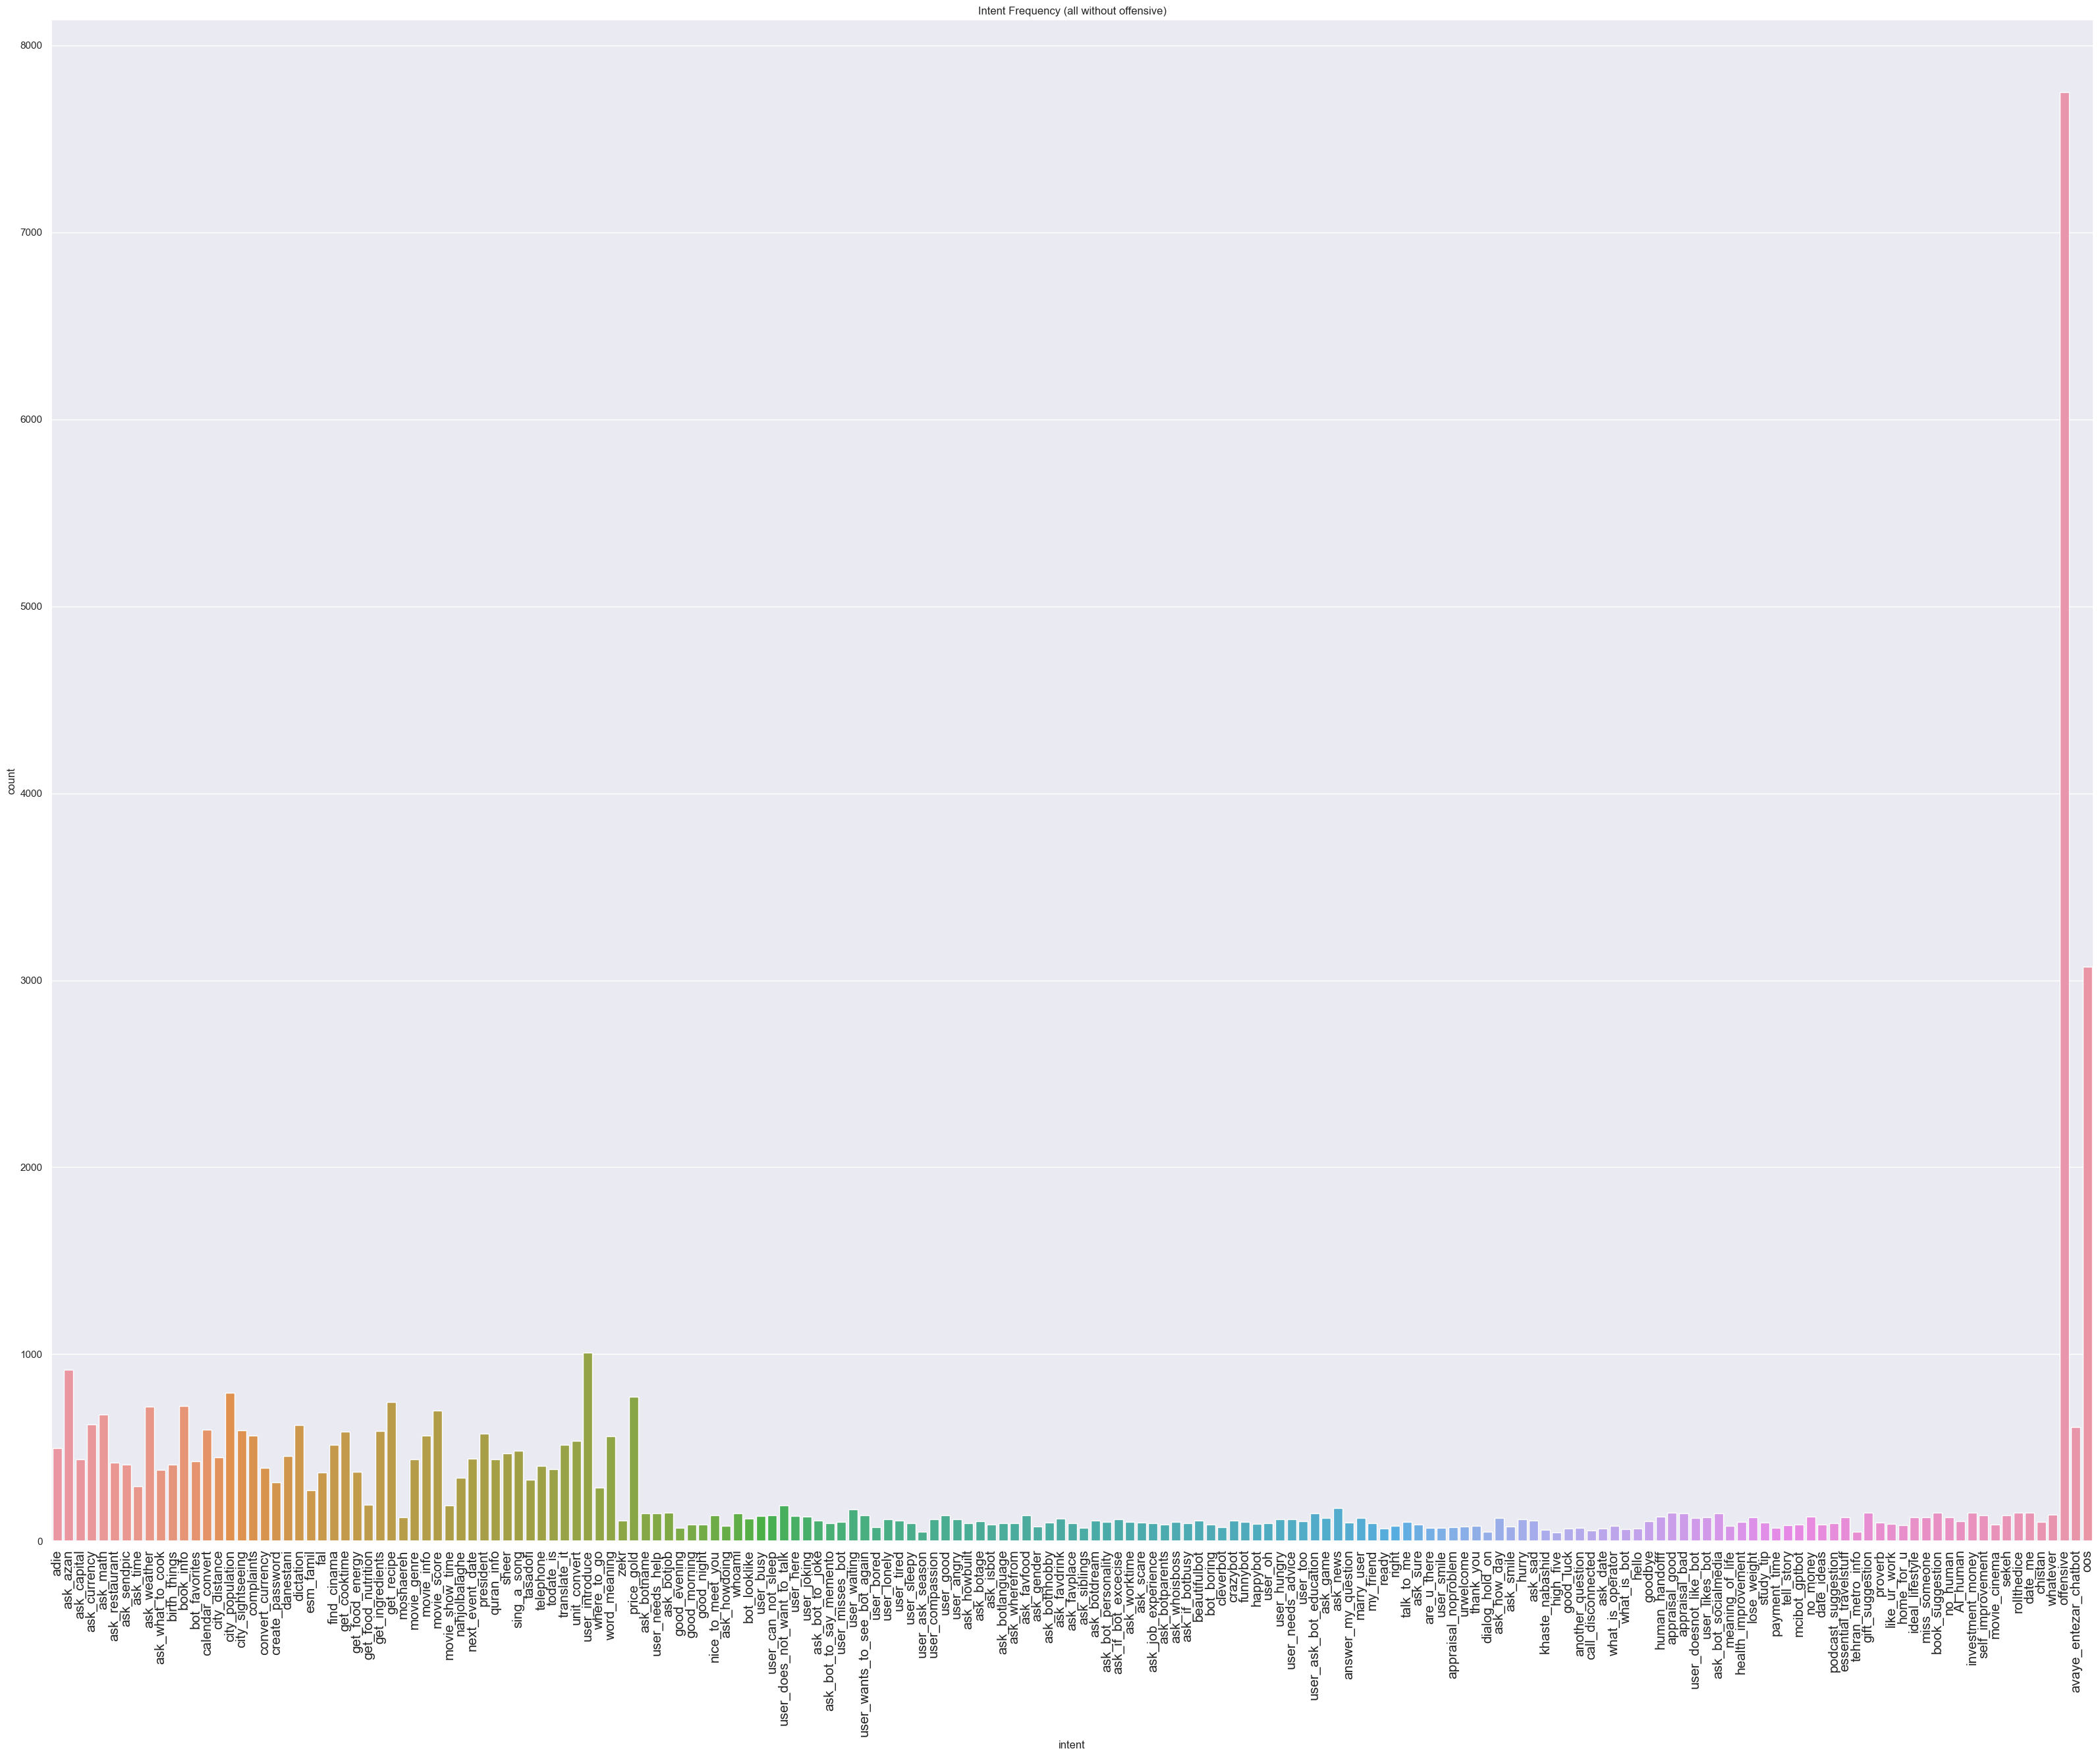

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(40,30)})  #,font_scale=1
g = sns.countplot(data=df,x='intent')
g.set_title('Intent Frequency (all without offensive)')
g.set_xticklabels(labels=df.intent.unique() ,rotation = 90, fontsize=15)
plt.savefig('pictures/all_intent_frequency.png',bbox_inches='tight')#,pad_inches=0)
plt.show()

In [32]:
print("number of labels(classes):",df.intent.nunique())
print(sorted(df.intent.unique()))
df.intent.value_counts()

number of labels(classes): 177
['AI_human', 'adie', 'another_question', 'answer_my_question', 'appraisal_bad', 'appraisal_good', 'appraisal_noproblem', 'are_u_there', 'ask_azan', 'ask_bot_personality', 'ask_bot_socialmedia', 'ask_bot_to _joke', 'ask_bot_to_say_memento', 'ask_botage', 'ask_botdream', 'ask_bothhobby', 'ask_botjob', 'ask_botlanguage', 'ask_botname', 'ask_botparents', 'ask_capital', 'ask_currency', 'ask_date', 'ask_favdrink', 'ask_favfood', 'ask_favplace', 'ask_game', 'ask_gender', 'ask_how_day', 'ask_howbuilt', 'ask_howdoing', 'ask_if_bot_excecise', 'ask_if_botbusy', 'ask_isbot', 'ask_job_experience', 'ask_math', 'ask_news', 'ask_restaurant', 'ask_sad', 'ask_scare', 'ask_sendpic', 'ask_siblings', 'ask_smile', 'ask_sure', 'ask_time', 'ask_weather', 'ask_what_to_cook', 'ask_wherefrom', 'ask_whoisboss', 'ask_worktime', 'avaye_entezar_chatbot', 'beautifulbot', 'birth_things', 'book_info', 'book_suggestion', 'bot_boring', 'bot_favorites', 'bot_looklike', 'calendar_convert', 'c

intent
offensive            7748
oos                  3073
user_introduce       1008
ask_azan              916
city_population       793
                     ... 
call_disconnected      57
tehran_metro_info      50
user_ask_season        50
dialog_hold_on         50
high_five              48
Name: count, Length: 177, dtype: int64

In [33]:
df.shape

(49694, 4)

## slot

In [34]:
import matplotlib.pyplot as plt

In [35]:
all_slots = []
[all_slots.extend(i.split()) for i in df_with_slots.slots]
pd.Series(all_slots).value_counts()

o                161514
b-city             3217
i-food_name        2831
i-movie            2639
b-food_name        2450
                  ...  
b-ingredient3         2
b-writer_name         1
i-writer_name         1
i-radical             1
i-ingredient1         1
Name: count, Length: 144, dtype: int64

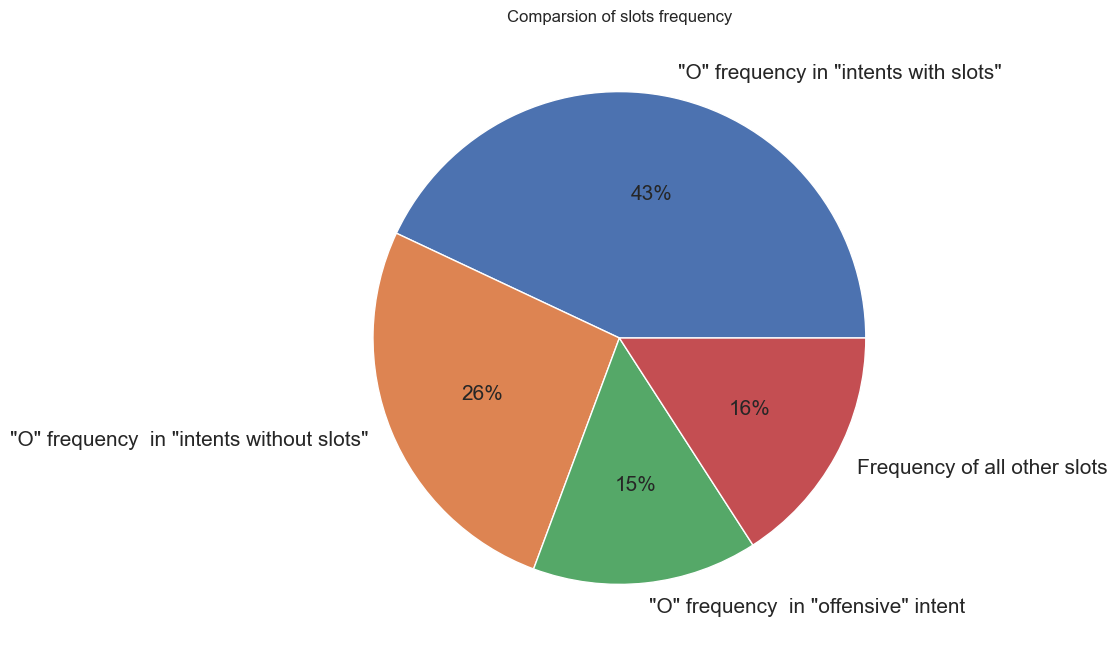

In [36]:
# [33734 , 20651 , 11590, 12458]
# ['o_with_slots', 'o_without_slots', 'o_offensive' , 'all_other_slots']
plt.figure(figsize=(11,8))
plt.pie(x=[33734 , 20651 , 11590, 12458],
        labels=['"O" frequency in "intents with slots"', '"O" frequency  in "intents without slots"', '"O" frequency  in "offensive" intent' , 'Frequency of all other slots'],
       autopct='%.0f%%',
       textprops={'fontsize':15})
# plt.legend(fontsize=10, loc="lower left")
plt.title("Comparsion of slots frequency")
plt.savefig('pictures/Comparsion of slots frequency.png'.replace(" ","_"),bbox_inches='tight')#,pad_inches=0)

plt.show()

In [37]:
pd.Series(all_slots).value_counts().sum() - 33734 - 20651 - 11590

147297

In [38]:
pd.DataFrame(pd.Series(all_slots).value_counts(),columns=['frequency of slots']).to_excel('frequency_of_slots.xlsx')

In [39]:
pd.DataFrame(pd.Series(all_slots).value_counts(),columns=['frequency of slots'])[:30] #.drop('o',axis=0)[:30] #.to_excel('frequency_of_slots.xlsx')

,frequency of slots


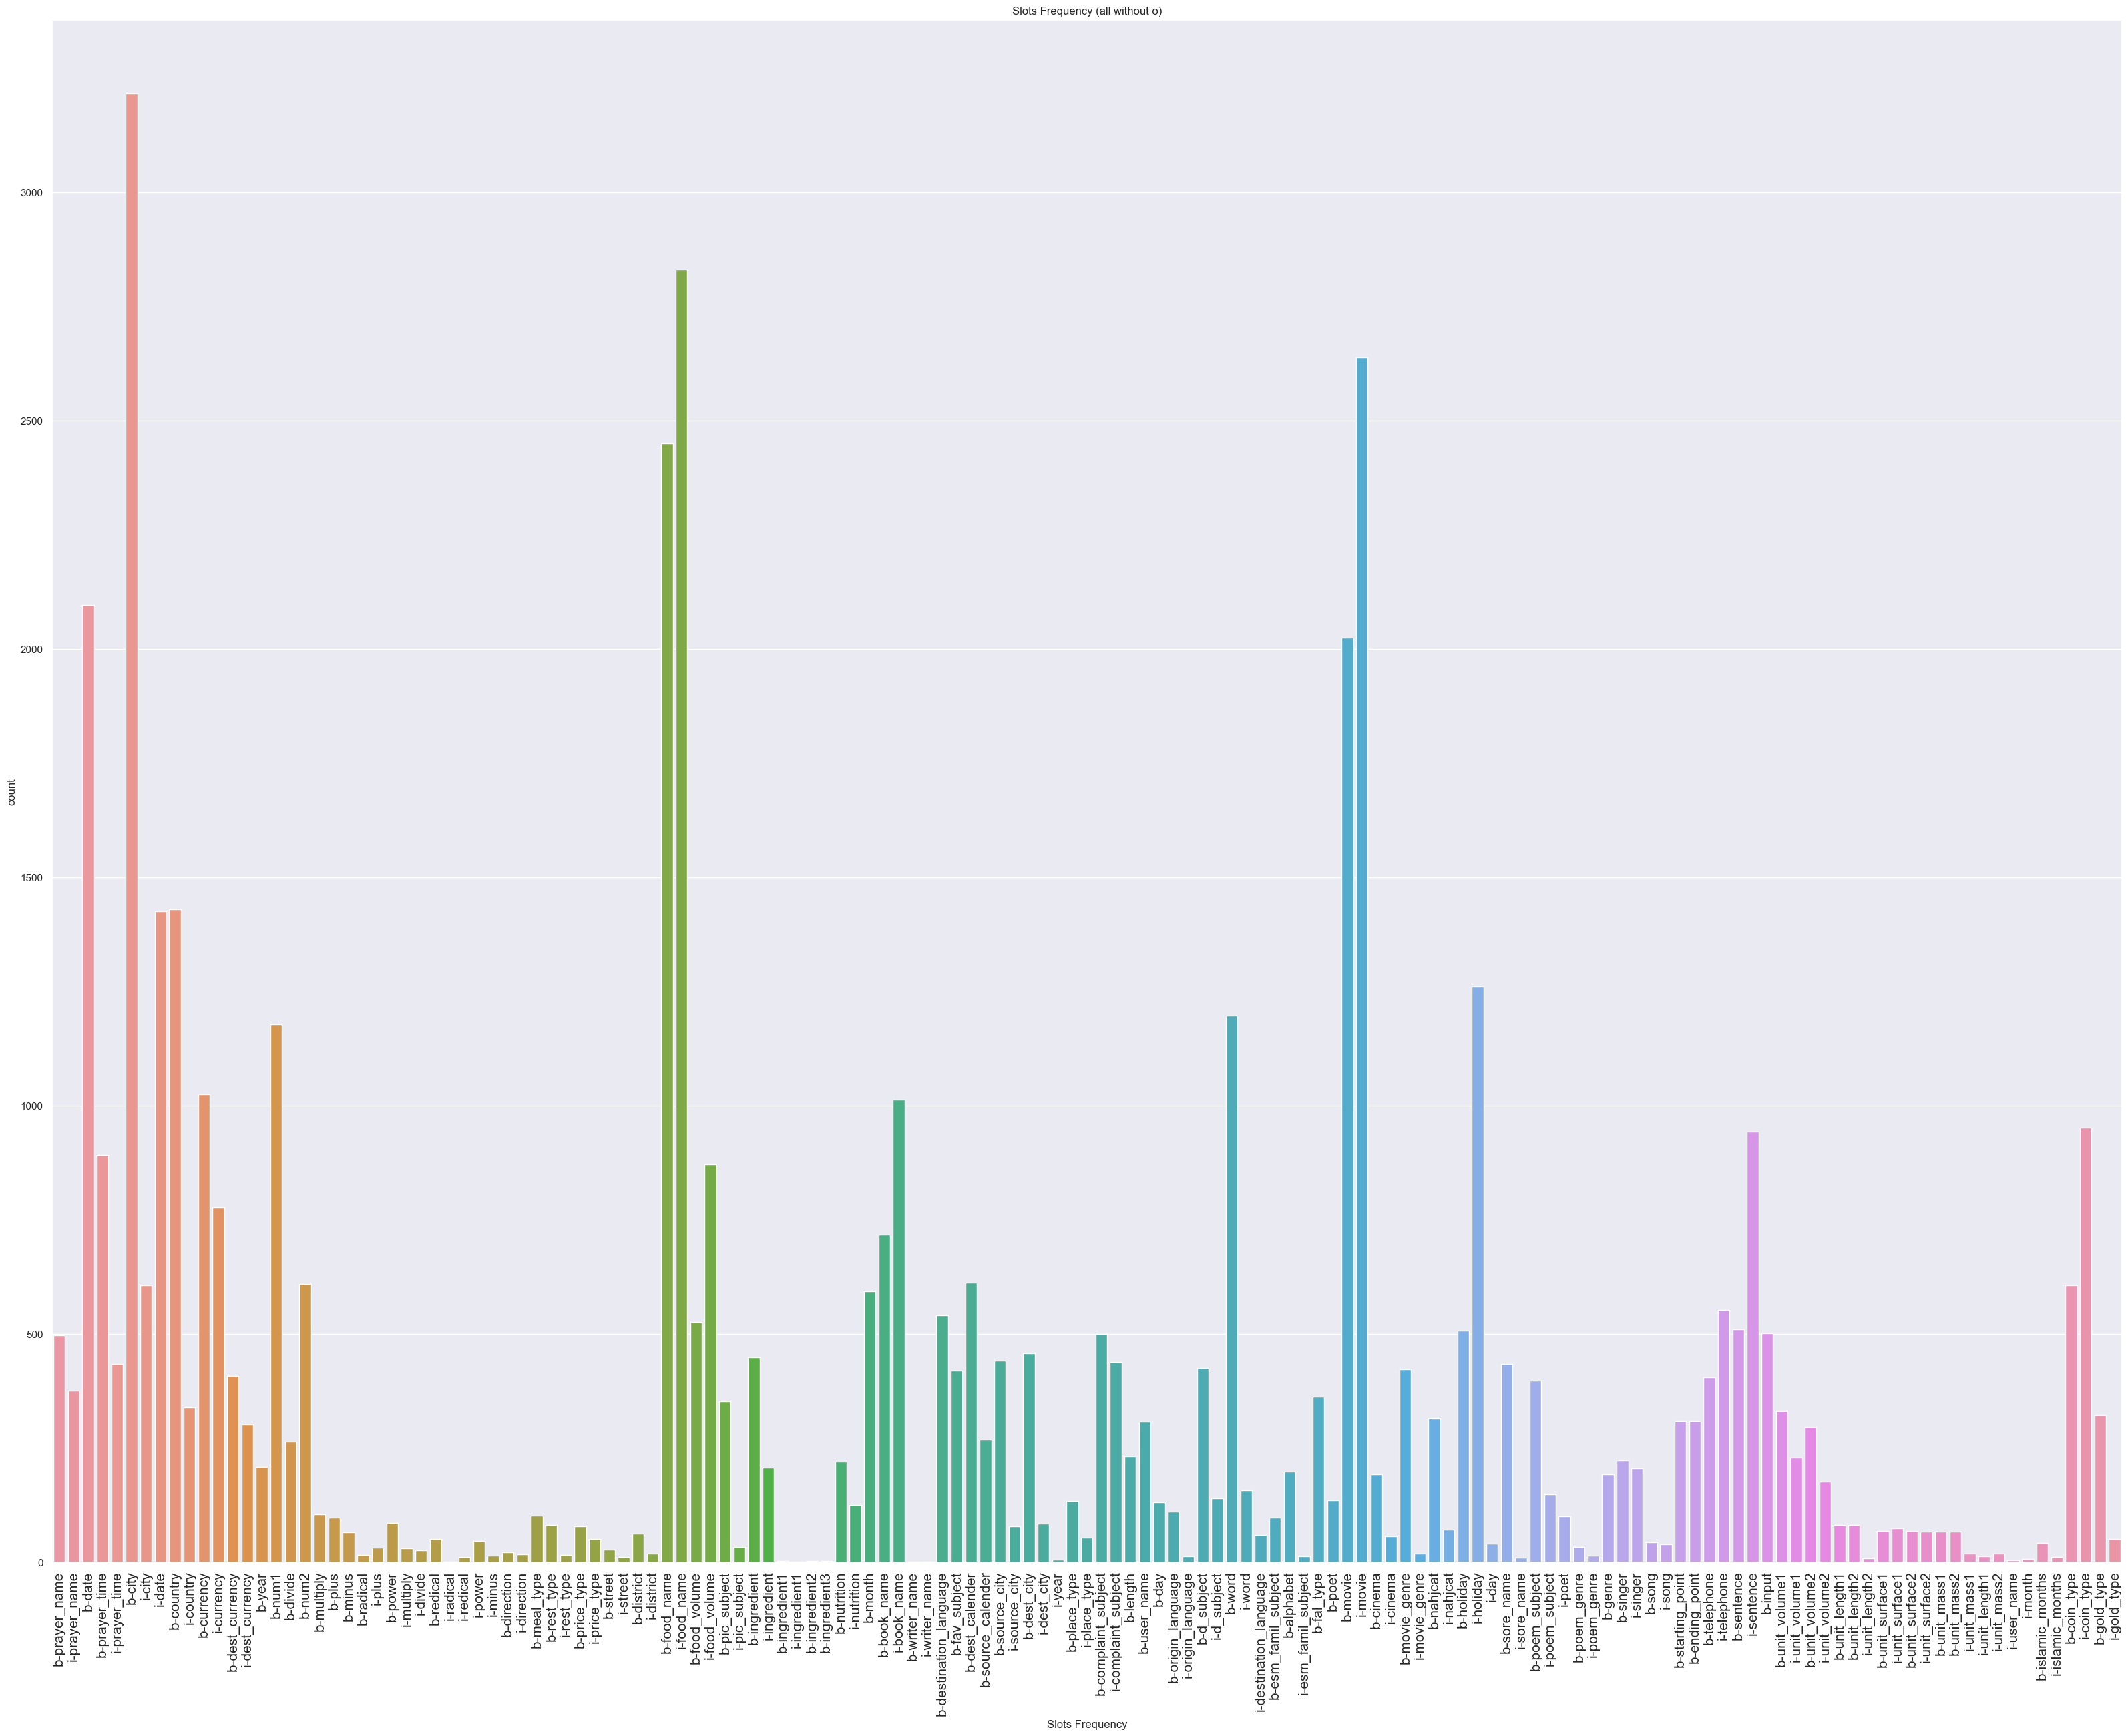

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
dff = pd.DataFrame(pd.Series(all_slots),columns=['Slots Frequency'])
dff.drop(dff[dff['Slots Frequency'] == 'o'].index,inplace=True)
sns.set(rc={'figure.figsize':(40,30)})  #,font_scale=1
g = sns.countplot(data=dff,x='Slots Frequency')
g.set_title('Slots Frequency (all without o)')
g.set_xticklabels(labels=dff['Slots Frequency'].unique() ,rotation = 90, fontsize=15)
plt.savefig('pictures/slots_frequency.png',bbox_inches='tight')#,pad_inches=0)
plt.show()

## text

In [41]:
dict(pd.Series([len(i.split()) for i in df['text']]).value_counts())

{6: 5385,
 7: 5253,
 5: 5225,
 8: 5014,
 4: 4689,
 9: 4495,
 3: 3972,
 2: 2976,
 10: 2918,
 11: 1805,
 12: 1413,
 1: 1278,
 13: 1163,
 14: 937,
 15: 648,
 16: 506,
 17: 407,
 18: 299,
 19: 236,
 20: 158,
 21: 152,
 22: 98,
 23: 97,
 24: 63,
 25: 60,
 27: 49,
 26: 46,
 28: 38,
 30: 31,
 29: 30,
 34: 17,
 31: 17,
 39: 16,
 37: 15,
 35: 14,
 33: 14,
 32: 14,
 46: 12,
 36: 12,
 40: 9,
 38: 9,
 41: 9,
 43: 8,
 44: 8,
 48: 6,
 49: 6,
 47: 5,
 50: 5,
 42: 5,
 45: 5,
 51: 4,
 53: 4,
 70: 3,
 58: 3,
 68: 3,
 52: 3,
 55: 3,
 64: 3,
 60: 2,
 77: 2,
 69: 2,
 113: 1,
 54: 1,
 88: 1,
 141: 1,
 63: 1,
 56: 1,
 76: 1,
 78: 1,
 87: 1,
 86: 1,
 65: 1,
 96: 1,
 73: 1,
 57: 1,
 61: 1}

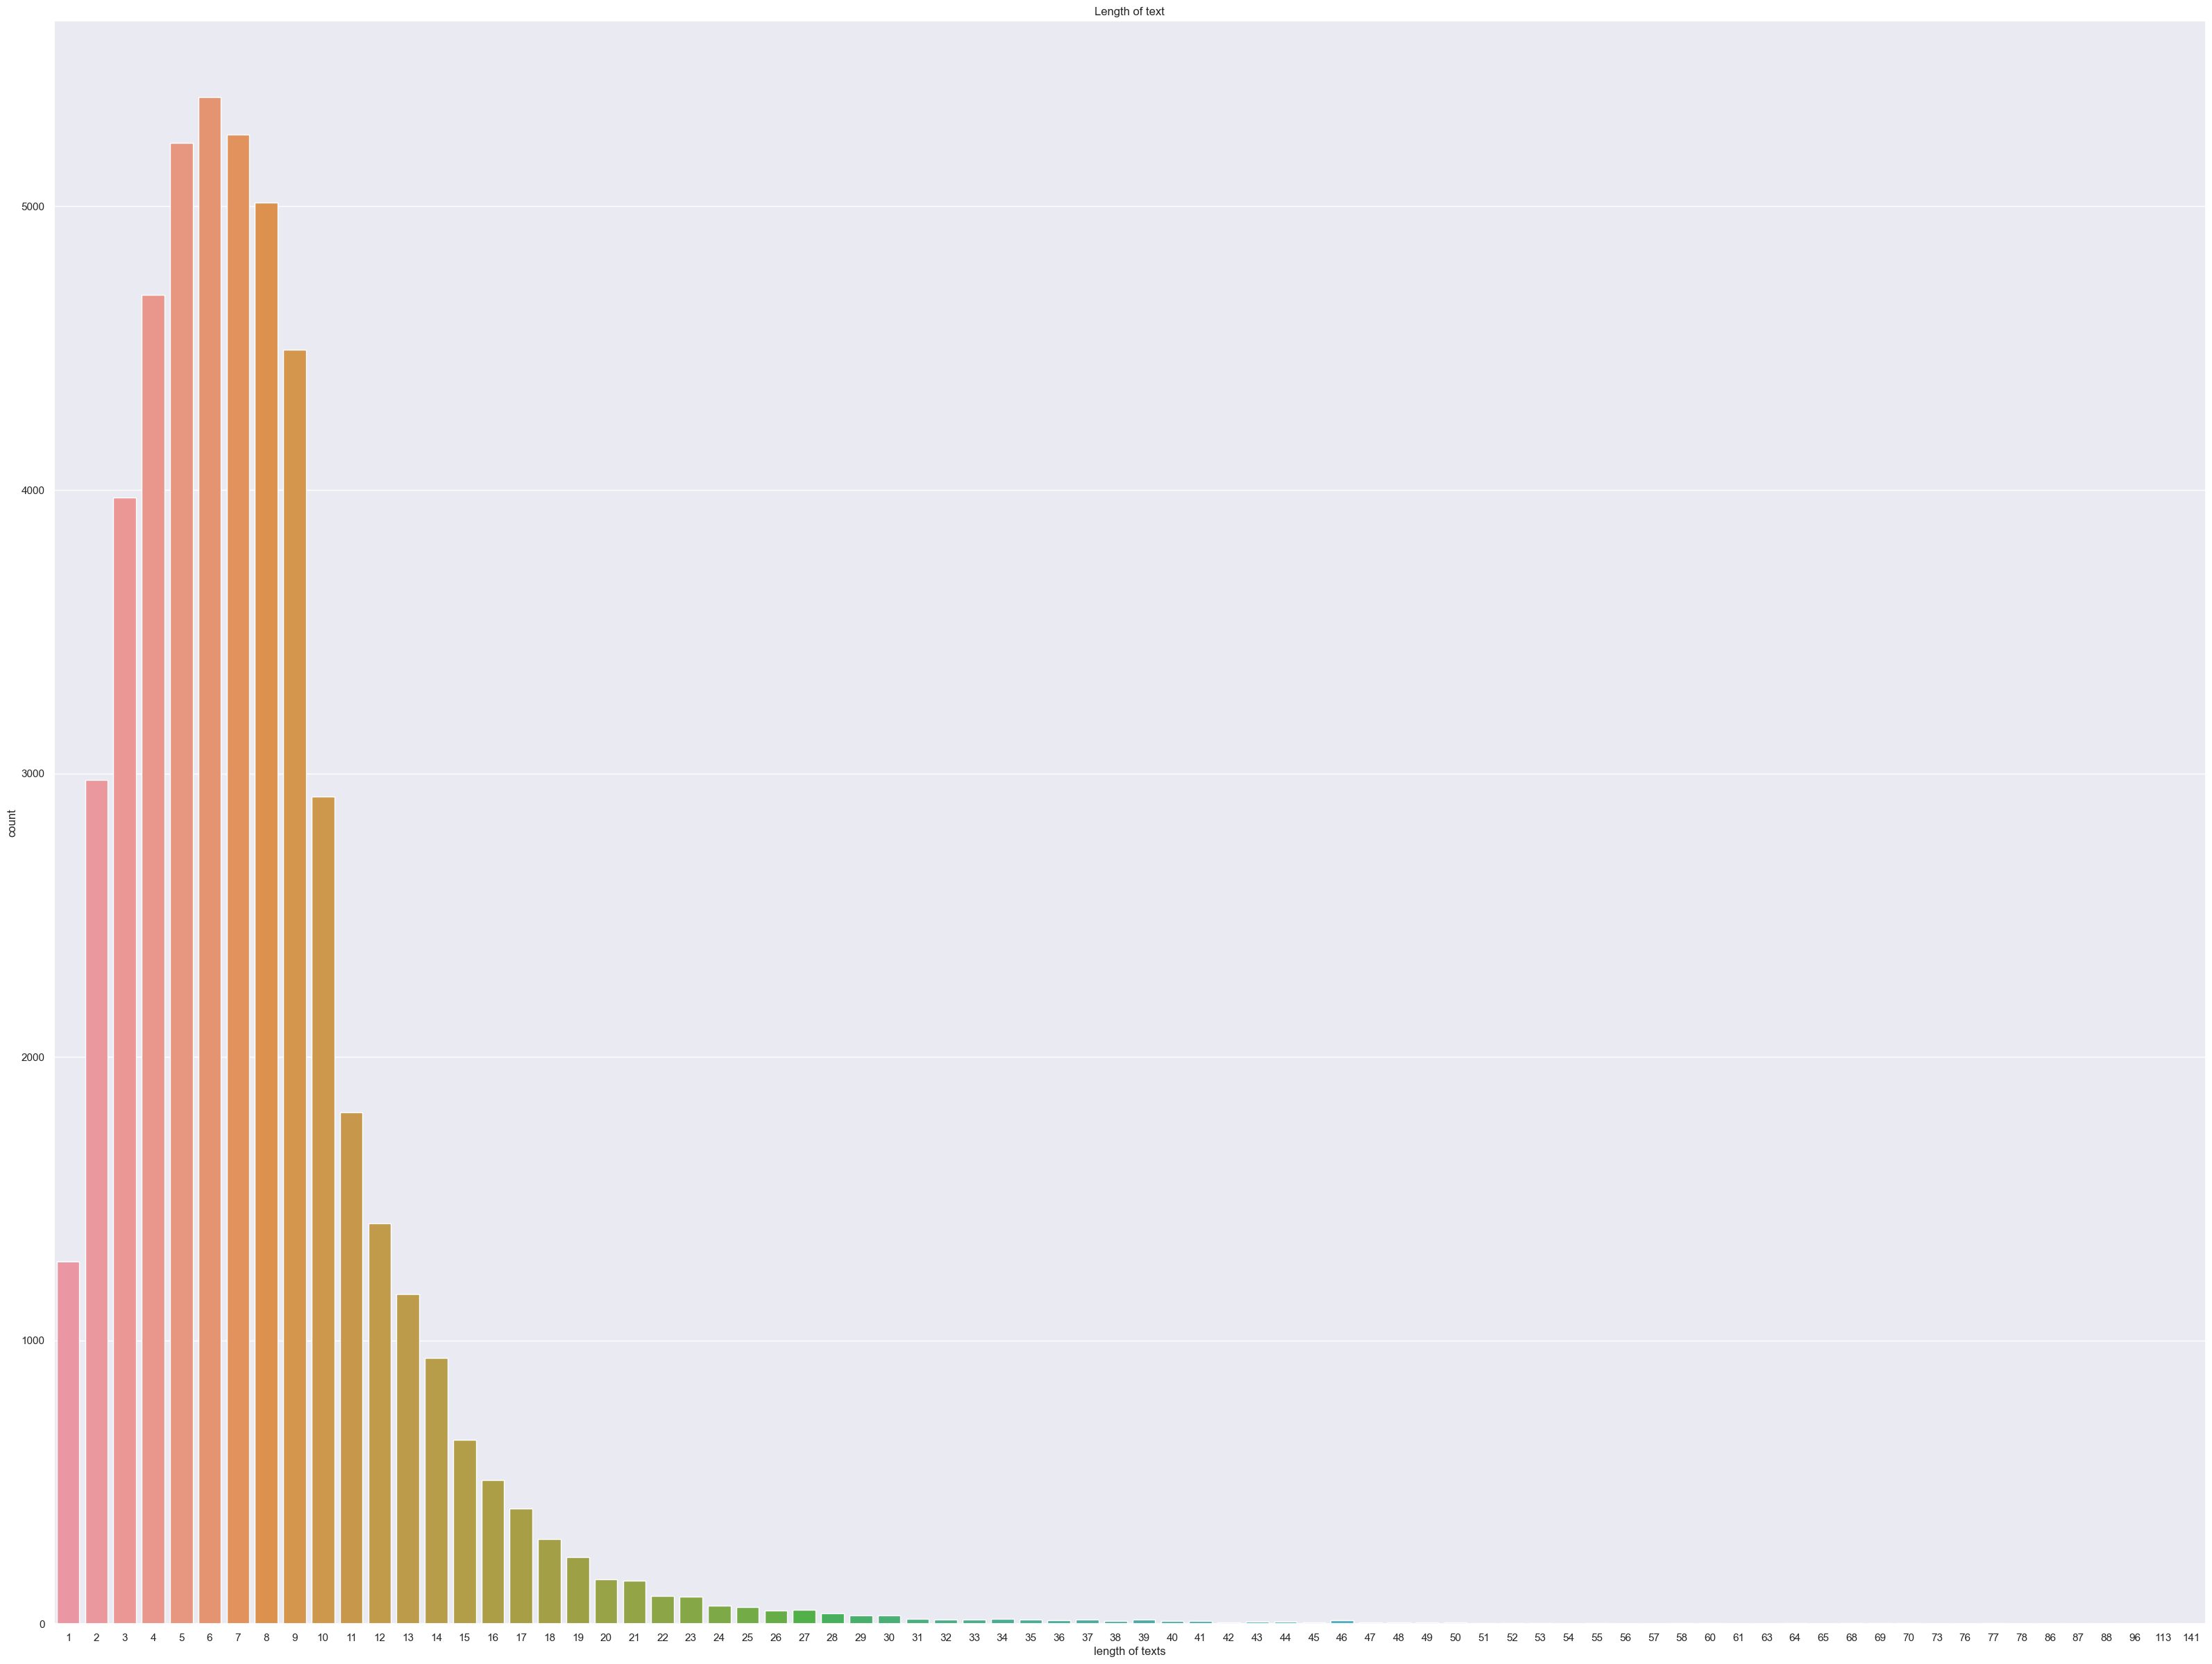

In [42]:
import seaborn as sns
g = sns.countplot(data=pd.DataFrame(pd.Series([len(i.split()) for i in df['text']]),columns=['length of texts']),x='length of texts')
g.set_title('Length of text')
plt.savefig('pictures/length_of_texts.png',bbox_inches='tight')#,pad_inches=0)
plt.show()

In [43]:
pd.Series([len(i.split()) for i in df['text']]).describe(percentiles=[.25,.5,.75,.9,.99])

count    49694.000000
mean         7.499859
std          5.016335
min          1.000000
25%          4.000000
50%          7.000000
75%          9.000000
90%         13.000000
99%         25.000000
max        141.000000
dtype: float64

## K-Fold

In [44]:
len(df)

49694

In [45]:
from sklearn.model_selection import KFold, GroupKFold, train_test_split

FOLD = 9  # 9     #done 0 1 2 3 4 5 7 8
DATE = '0621'

gkf = GroupKFold(n_splits=10)#, shuffle=True, random_state=42)   # is not randomized at all random_state=None
# kf = KFold(n_splits=10, shuffle=True, random_state=43)  # kf.get_n_splits()
# result = next(gkf.split(df, df.intent, df.pattern_id ))
# print(result)
# pd.merge(df.iloc[result[0]],df.iloc[result[1]],on=['pattern_id'])
print(gkf.get_n_splits(df, df.intent, df.pattern_id ))

train_valid_index = list(gkf.split(df, df.intent, df.pattern_id ))[FOLD][0]
from sklearn.model_selection import train_test_split
train_index, valid_index = train_test_split(train_valid_index, test_size=0.10, random_state=42, shuffle = True)

test_index = list(gkf.split(df, df.intent, df.pattern_id ))[FOLD][1]
print('train+valid length:',len(train_valid_index),train_valid_index)
print('test length:',len(test_index),test_index)

10
train+valid length: 44725 [    0     1     2 ... 49691 49692 49693]
test length: 4969 [    5    18    36 ... 49661 49671 49681]


# observing folds for conflicts

In [46]:
# Fold 0
# train+valid length: 32476 [    0     1     2 ... 36082 36083 36084]
# test length: 3609 [   19    33    34 ... 36064 36074 36075]

# Fold 1
# train+valid length: 32476 [    0     1     2 ... 36082 36083 36084]
# test length: 3609 [   47    48    49 ... 36055 36065 36076]

# Fold 2
# train+valid length: 32476 [    0     1     2 ... 36082 36083 36084]
# test length: 3609 [   69    70    71 ... 36056 36066 36077]

# Fold 3
# train+valid length: 32476 [    0     1     2 ... 36082 36083 36084]
# test length: 3609 [   15    16    17 ... 36067 36072 36078]

# Fold 4
# train+valid length: 32476 [    0     1     9 ... 36082 36083 36084]
# test length: 3609 [    2     3     4 ... 36059 36068 36079]

# Fold 5
# train+valid length: 32477 [    0     1     2 ... 36082 36083 36084]
# test length: 3608 [  107   108   109 ... 36060 36069 36080]

# Fold 6
# train+valid length: 32477 [    0     1     2 ... 36082 36083 36084]
# test length: 3608 [   30    31    32 ... 36070 36071 36081]

# Fold 7
# train+valid length: 32477 [    2     3     4 ... 36081 36083 36084]
# test length: 3608 [    0     1     9 ... 36061 36073 36082]

# Fold 8
# train+valid length: 32477 [    0     1     2 ... 36081 36082 36084]
# test length: 3608 [   39    40    41 ... 36052 36062 36083]

# Fold 9
# train+valid length: 32477 [    0     1     2 ... 36081 36082 36083]
# test length: 3608 [   13    14    36 ... 36053 36063 36084]

In [47]:
train_df = df.iloc[train_index]
valid_df = df.iloc[valid_index]
test_df = df.iloc[test_index]

In [48]:
train_text = train_df["text"]
train_intent_label = train_df["intent"]
train_slot_label = train_df["slots"]

valid_text = valid_df["text"]
valid_intent_label = valid_df["intent"]
valid_slot_label = valid_df["slots"]

test_text = test_df["text"]
test_intent_label = test_df["intent"]
test_slot_label = test_df["slots"]

In [49]:
# from sklearn.model_selection import train_test_split
# train_text, valid_text, train_intent_label, valid_intent_label, train_slot_label, valid_slot_label  = train_test_split(df['text'], df['intent'], df['slots'],
#                                                                     test_size=0.15,
#                                                                     shuffle = True,
#                                                                     random_state = 42)#,
#                                                                     # stratify=df['intent'])

# train_text, valid_test_text, train_labels, valid_test_labels = train_test_split(df['text'], df['intent'], df['slots']
#                                                                     test_size=0.15,
#                                                                     shuffle = True,
#                                                                     random_state = 42,
#                                                                     stratify=df['intent'])

In [50]:
print(train_text[:2])
print(train_intent_label[:2])
print(train_slot_label[:2])

14350          برای پخت کشک و بادمجان چی نیازه؟
23720    برای گستاخ تعریفی دقیق و واضح بفرمایید
Name: text, dtype: object
14350    get_ingredients
23720       word_meaning
Name: intent, dtype: object
14350    o o b-food_name i-food_name i-food_name o o
23720                             o b-word o o o o o
Name: slots, dtype: object


In [51]:
train_text = train_text.values
train_intent_label = train_intent_label.values
train_slot_label = train_slot_label.values

valid_text = valid_text.values
valid_intent_label = valid_intent_label.values
valid_slot_label = valid_slot_label.values

test_text = test_text.values
test_intent_label = test_intent_label.values
test_slot_label = test_slot_label.values

In [52]:
import pandas as pd
import numpy as np

def process_dataset(text_dataset, intent_label_dataset, slot_label_dataset):
    output_dataset = list()
    for i in range(len(intent_label_dataset)):
        slot_tokens = []
        slot_labels = []

        for token, token_label in zip(text_dataset[i].split(), slot_label_dataset[i].split()):
            slot_tokens.append(token)
            slot_labels.append(token_label)

        output_dataset.append({"text": text_dataset[i],
                               "intent_label": intent_label_dataset[i],
                               "slot_tokens": slot_tokens,
                               "slot_labels": slot_labels})

    return pd.DataFrame(output_dataset)

train_df = process_dataset(train_text, train_intent_label, train_slot_label)
valid_df = process_dataset(valid_text, valid_intent_label, valid_slot_label)
test_df = process_dataset(test_text, test_intent_label, test_slot_label)

In [53]:
test_df

,text,intent_label,slot_tokens,slot_labels
0,سر خاک پدربزرگم میخام براش دعای عهد بخونم برام...,adie,"[سر, خاک, پدربزرگم, میخام, براش, دعای, عهد, بخ...","[o, o, o, o, o, b-prayer_name, i-prayer_name, ..."
1,مادر بزرگم امروز فوت کرده. برای رفع فشار قبر د...,adie,"[مادر, بزرگم, امروز, فوت, کرده., برای, رفع, فش...","[o, o, o, o, o, o, o, o, o, o, b-prayer_name, ..."
2,برای باز شدن گره‌های زندگی خیلی دعای مشلول توص...,adie,"[برای, باز, شدن, گره‌های, زندگی, خیلی, دعای, م...","[o, o, o, o, o, o, o, b-prayer_name, o, o, o, ..."
3,برای باز شدن گره‌های زندگی خیلی دعای دعای عهد ...,adie,"[برای, باز, شدن, گره‌های, زندگی, خیلی, دعای, د...","[o, o, o, o, o, o, o, b-prayer_name, i-prayer_..."
4,برای باز شدن گره‌های زندگی خیلی دعای افتتاح تو...,adie,"[برای, باز, شدن, گره‌های, زندگی, خیلی, دعای, ا...","[o, o, o, o, o, o, o, b-prayer_name, o, o, o, ..."
...,...,...,...,...
4964,ارزش گل از نقاط مختلف زمين چقدر است,oos,"[ارزش, گل, از, نقاط, مختلف, زمين, چقدر, است]","[o, o, o, o, o, o, o, o]"
4965,بازي با چند بازيكن از هر تيم صورت مي گيرد,oos,"[بازي, با, چند, بازيكن, از, هر, تيم, صورت, مي,...","[o, o, o, o, o, o, o, o, o, o]"
4966,خطاهاي شخصي بازيكن را نام ببريد,oos,"[خطاهاي, شخصي, بازيكن, را, نام, ببريد]","[o, o, o, o, o, o]"
4967,مشخصات تور واليبال رو بهم میگی,oos,"[مشخصات, تور, واليبال, رو, بهم, میگی]","[o, o, o, o, o, o]"


In [54]:
# Check that if number of tokens in sentences is equal to its slots number or not
for i in range(len(train_df)):
    slots = train_df['slot_labels'][i]
    tokens = train_df['slot_tokens'][i]
    assert len(slots) == len(tokens), f"sentence length doesn't match to slots length i = {i}, tokens={tokens} slots = {slots}"

# Tokenization

In [42]:
# Load the BERT tokenizer
from transformers import AutoTokenizer
model_name = "xlm-roberta-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)

7.503974957766074
141


<Axes: >

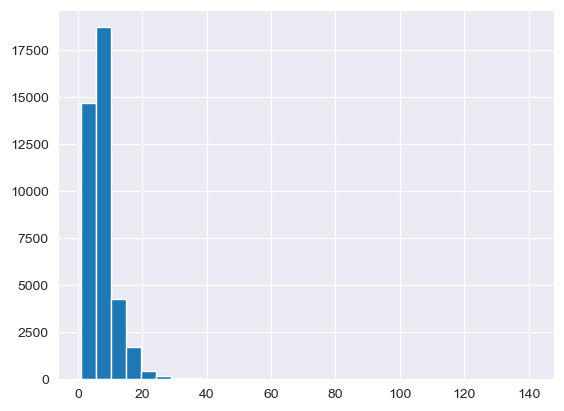

In [43]:
import numpy as np
seq_len = [len(i.split()) for i in train_df['text']]
print(np.mean(seq_len))
print(np.max(seq_len))
pd.Series(seq_len).hist(bins = 30)

### label2id & id2label

In [56]:
import json
intent_id2label = dict([(i,v) for i,v in enumerate(sorted(df.intent.unique()))])
intent_label2id = dict([(v,k) for k,v in intent_id2label.items()])
print(len(intent_label2id))
with open('intent_label2id.json', 'w') as json_file:
    json.dump(intent_label2id, json_file, indent=4)

print("intent_label2id saved as intent_label2id.json")

177
intent_label2id saved as intent_label2id.json


In [57]:
slot_label = []
[slot_label.extend(i.split()) for i in train_slot_label]
[slot_label.extend(i.split()) for i in valid_slot_label]
[slot_label.extend(i.split()) for i in test_slot_label]
slot_label2id = dict([(y,x) for x,y in enumerate(sorted(set(slot_label)))])
slot_id2label = dict([(y,x) for x,y in slot_label2id.items()])
print(len(slot_label2id))
with open('slot_label2id.json', 'w') as json_file:
    json.dump(slot_label2id, json_file, indent=4)

print("slot_label2id saved as slot_label2id.json")

144
slot_label2id saved as slot_label2id.json


In [58]:
if pd.Series([len(i.split()) for i in df.text]).describe()['min'] < 1:
    print(pd.Series([len(i.split()) for i in df.text]).describe())
    df["Sentence"]=df["text"].str.split()
    df["WordsCount"]=df["Sentence"].apply(lambda x: len(x))
    df=df[(df["WordsCount"]>= 1)]# &(df["WordsCount"]<=8)]
    df = df.drop(['Sentence','WordsCount'],axis=1)
print(pd.Series([len(i.split()) for i in df.text]).describe())

count    49694.000000
mean         7.499859
std          5.016335
min          1.000000
25%          4.000000
50%          7.000000
75%          9.000000
max        141.000000
dtype: float64


In [47]:
df = df.reset_index(drop=True)

### Tokenize_and_align_slot_labels

In [48]:
MAX_SEQ_LEN = 64

def tokenize_and_align_labels(examples, slot_label2id=slot_label2id, intent_label2id=intent_label2id):
    tokenized_inputs = tokenizer(examples["slot_tokens"],truncation=True, padding="max_length", max_length=MAX_SEQ_LEN,
                               is_split_into_words=True, return_token_type_ids=False)

    slot_labels = []
    intent_label = []
    for i, label in enumerate(examples["slot_labels"]):
        word_ids = tokenized_inputs.word_ids()
        previous_word_id = None
        label_ids = []
        for word_id in word_ids:  # Set the special tokens to 0.
            if word_id is None: # Special tokens have a word id "None". We set the label to -100 so they are automatically ignored in the loss function.
                label_ids.append(-100)
            elif word_id != previous_word_id: # We set the label for the first token of each word.
                label_ids.append(slot_label2id[examples["slot_labels"][word_id]])
            else:  # For the other tokens in a word, we set the label to either the current label or -100, depending on the label_all_tokens flag.
                # label_ids.append(label[word_idx] if label_all_tokens else -100)
                label_ids.append(-100)
            previous_word_id = word_id

        slot_labels.append(label_ids)
        intent_label.append(intent_label2id[examples["intent_label"]])
    tokenized_inputs["slot_labels"] = slot_labels[0]
    tokenized_inputs["intent_label"] = intent_label[0]
    # x, y_slot, y_intent
    return tokenized_inputs['input_ids'], tokenized_inputs['attention_mask'], tokenized_inputs['slot_labels'], tokenized_inputs['intent_label']

In [49]:
from tqdm.notebook import tqdm

tokenized_train = {'input_ids':[], 'attention_mask':[], 'slot_labels':[], 'intent_label':[]}
for i in tqdm(range(len(train_df))):
    tokenized_train['input_ids'].append(tokenize_and_align_labels(train_df.iloc[i])[0])
    tokenized_train['attention_mask'].append(tokenize_and_align_labels(train_df.iloc[i])[1])
    tokenized_train['slot_labels'].append(tokenize_and_align_labels(train_df.iloc[i])[2])
    tokenized_train['intent_label'].append(tokenize_and_align_labels(train_df.iloc[i])[3])

tokenized_valid = {'input_ids':[], 'attention_mask':[], 'slot_labels':[], 'intent_label':[]}
for i in tqdm(range(len(valid_df))):
    tokenized_valid['input_ids'].append(tokenize_and_align_labels(valid_df.iloc[i])[0])
    tokenized_valid['attention_mask'].append(tokenize_and_align_labels(valid_df.iloc[i])[1])
    tokenized_valid['slot_labels'].append(tokenize_and_align_labels(valid_df.iloc[i])[2])
    tokenized_valid['intent_label'].append(tokenize_and_align_labels(valid_df.iloc[i])[3])

tokenized_test = {'input_ids':[], 'attention_mask':[], 'slot_labels':[], 'intent_label':[]}
for i in tqdm(range(len(test_df))):
    tokenized_test['input_ids'].append(tokenize_and_align_labels(test_df.iloc[i])[0])
    tokenized_test['attention_mask'].append(tokenize_and_align_labels(test_df.iloc[i])[1])
    tokenized_test['slot_labels'].append(tokenize_and_align_labels(test_df.iloc[i])[2])
    tokenized_test['intent_label'].append(tokenize_and_align_labels(test_df.iloc[i])[3])

  0%|          | 0/40252 [00:00<?, ?it/s]

  0%|          | 0/4473 [00:00<?, ?it/s]

  0%|          | 0/4969 [00:00<?, ?it/s]

In [50]:
train_df.iloc[2126]

text            این داماهی جدیداً یه آهنگ خونده خیلی ترند شده....
intent_label                                          sing_a_song
slot_tokens     [این, داماهی, جدیداً, یه, آهنگ, خونده, خیلی, ت...
slot_labels        [o, b-singer, o, o, o, o, o, o, o, o, o, o, o]
Name: 2126, dtype: object

In [51]:
k = 1
print(len(tokenized_train['input_ids'])) # all of train
print(train_df.text[k])
print(len(tokenized_train['input_ids'][k]),tokenized_train['input_ids'][k])
print(len(tokenized_train['attention_mask'][k]),tokenized_train['attention_mask'][k])
print(len(tokenized_train['slot_labels'][k]),tokenized_train['slot_labels'][k])
print((tokenized_train['intent_label'][k]),tokenized_train['intent_label'][k])
print([slot_id2label[i] for i in tokenized_train['slot_labels'][k] if i != -100])

40252
برای گستاخ تعریفی دقیق و واضح بفرمایید
64 [0, 1012, 6302, 3503, 35862, 62032, 140, 80950, 65, 30844, 167315, 2889, 140, 2929, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
64 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
64 [-100, 143, 76, -100, -100, 143, -100, 143, 143, 143, 143, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100]
175 175
['o', 'b-word', 'o', 'o', 'o', 'o', 'o']


In [52]:
# check length for correct alligning
for i in range(len(tokenized_train['input_ids'])):
    if len(tokenized_train['input_ids'][i]) == len(tokenized_train['slot_labels'][i]):
        continue
    else:
        print(i, tokenized_train['input_ids'][i], tokenized_train['slot_labels'][i])

In [53]:
tokenized_train.keys()

dict_keys(['input_ids', 'attention_mask', 'slot_labels', 'intent_label'])

### Convert to Tensors

Before feeding the data to the model, **integer sequences** should be cobverted into tensors.  

In [56]:
import torch

In [57]:
# for train set
train_input_ids = torch.tensor(tokenized_train['input_ids'])
train_attention_mask = torch.tensor(tokenized_train['attention_mask'])
train_label_intent = torch.tensor(tokenized_train['intent_label'])
train_label_slot = torch.tensor(tokenized_train['slot_labels'])

# for validation set
valid_input_ids = torch.tensor(tokenized_valid['input_ids'])
valid_attention_mask = torch.tensor(tokenized_valid['attention_mask'])
valid_label_intent = torch.tensor(tokenized_valid['intent_label'])
valid_label_slot = torch.tensor(tokenized_valid['slot_labels'])

# # for test set
test_input_ids = torch.tensor(tokenized_test['input_ids'])
test_attention_mask = torch.tensor(tokenized_test['attention_mask'])
test_label_intent = torch.tensor(tokenized_test['intent_label'])
test_label_slot = torch.tensor(tokenized_test['slot_labels'])

### DataLoaders

We create DataLoaders for train and validation sets for **automatic mini-batch processing**. The `DataLoader` class provides the Python iterable which is memory efficient.

The `TensorDataset` wraps tensor such that each sample will be retrieved by indexing tensors along the first dimension. The `RandomSampler` class helps **shuffling** the train set; while in validation set, `SequentialSampler` is enough.

In [58]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
BATCH_SIZE = 128

# wrap tensors
train_data = TensorDataset(train_input_ids, train_attention_mask, train_label_intent, train_label_slot)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

# wrap tensors
valid_data = TensorDataset(valid_input_ids, valid_attention_mask, valid_label_intent, valid_label_slot)
# sampler for sampling the data during training
valid_sampler = SequentialSampler(valid_data)
# dataLoader for validation set
valid_dataloader = DataLoader(valid_data, sampler = valid_sampler, batch_size=BATCH_SIZE)

# wrap tensors
test_data = TensorDataset(test_input_ids, test_attention_mask, test_label_intent, test_label_slot)
# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)
# dataLoader for validation set
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=BATCH_SIZE)

In [59]:
len(train_dataloader)

315

In [60]:
# ch_iterator = iter(train_dataloader)  # output of dataloader is iterator with 3 tensor that i defined
# one = next(ch_iterator)
# print('intent_label.size(batch_size, number of class)',one[2].shape)
# print('slot_label.size(batch_size,sequence_length)  ',one[3].shape)
# print(one)

# Model

### Import BERT Model

We import BERT Pretrained model from the [Hugging Face](https://huggingface.co/) `transformers` python package. Click [here](https://huggingface.co/transformers/model_doc/bert.html?highlight=bertmodel#transformers.BertModel) for more details on the BERT Model.

In [ ]:
# import BERT-base pretrained model
from transformers import AutoModelForSequenceClassification, AutoModel, AutoConfig

config = AutoConfig.from_pretrained("xlm-roberta-large")  # config.update({'output_hidden_states':True})
bert = AutoModel.from_pretrained("xlm-roberta-large",output_hidden_states=True)

/Users/precioux/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [ ]:
# freeze all the parameters for 2 epoch
for param in bert.parameters():
    param.requires_grad = True  # False=freezing True=Not freezing

### Define Model Architecture

As usual, for defining the network architecture, we define a class inheriting from `torch.nn.Module`. Remember to overwrite `__init__` and `forward` fucntions for making the network architecture, and the forward pass, respectively. As you may know, the `__init__` function is called once when instantiating an object from the class, and `forward` function is called whenever you call the object for making the predictions.

In [3]:
# AutoModel  with  output_hidden_states=True
# bert(one[0], one[1]).keys()   # odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states'])

In [4]:
config.hidden_size

NameError: name 'config' is not defined

In [5]:
config.output_hidden_states

NameError: name 'config' is not defined

In [6]:
import torch
import torch.nn as nn
from torch.cuda import amp
from torch.cuda.amp import autocast

class JointIntentAndSlotFillingModel(nn.Module):

    def __init__(self, bert, config, intent_labels_num, slot_labels_num):
        super(JointIntentAndSlotFillingModel,self).__init__()
        self.bert = bert
        self.fc1 = nn.Linear(config.hidden_size,config.hidden_size)
        self.dropout = nn.Dropout(0.1)
        self.intent_classifier = nn.Linear(config.hidden_size, intent_labels_num)
        self.fc2 = nn.Linear(config.hidden_size,config.hidden_size)
        self.slot_classifier = nn.Linear(config.hidden_size, slot_labels_num)
        # self.softmax_intent = nn.LogSoftmax(dim=1)
        # self.softmax_slot = nn.LogSoftmax(dim=2)


    # @amp.autocast()
    def forward(self, input_ids, attention_mask):
        # two outputs from BERT
        outputs = self.bert(input_ids, attention_mask)

        cls_token = outputs[1]   # cls_token is pooled_output     # torch.Size([8, 1024])
        dense_for_intent = self.fc1(cls_token)
        intent_logits = self.intent_classifier(self.dropout(dense_for_intent))      # torch.Size([8, 60])

        last_hidden_state = outputs[0]                            # torch.Size([8, 64, 1024])
        dense_for_slot = self.fc2(last_hidden_state)
        slot_logits = self.slot_classifier(self.dropout(dense_for_slot))  # torch.Size([8, 64, 109])

        return intent_logits, slot_logits
        # intent_classes = self.softmax_intent(intent_logits)                         # torch.Size([8, 60])
        # slot_classes = self.softmax_slot(slot_logits)                             # torch.Size([8, 109, 64])
        # return intent_classes, slot_classes

You have defined the `BERT_Arch` class. Now, it is time to instantiate an object from the class and sent it to GPU.

In [7]:
# pass the pre-trained BERT to our define architecture
model = JointIntentAndSlotFillingModel(bert, config,
                                       intent_labels_num=len(intent_label2id),
                                       slot_labels_num=len(slot_label2id))

# push the model to GPU
model = model.to('cuda')

NameError: name 'bert' is not defined

In [1]:
sum([p.numel() for p in model.parameters()])  # for 6 kernel Conv1d + last 4 hidden layer with NLLLOSS:  657420290
                                              # for 4 kernel Conv1d + last 4 hidden layer with NLLLOSS:  610229250

NameError: name 'model' is not defined

In [164]:
# # load model from before
# PATH = 'saved_weights.pt'
# model.load_state_dict(torch.load(PATH, map_location='cuda'), strict=True)

In [165]:
# model

# Training

### Optimizer

We use `AdamW` optimizer from `transformers` package. If you are interested for more details of the *Decoupled Weight Decay Regularization* algorithm, implemented in the class, please refer to [this paper](https://arxiv.org/abs/1711.05101).

In [166]:
import warnings

# optimizer from hugging face transformers
from transformers import AdamW
# define the optimizer
LEARNING_RATE = 5e-5  # 5e-3  5e-5better  5e-6
optimizer = AdamW(model.parameters(), lr = LEARNING_RATE)

/opt/conda/lib/python3.11/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [167]:
len(train_dataloader) # = number of steps in 1 epoch = 186-->193-->229

315

In [168]:
# scheduler
from transformers import get_linear_schedule_with_warmup
EPOCHS = 60
total_step =  len(train_dataloader) * EPOCHS
num_warmup_steps = 0.1 * len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_step)

### Loss function

As the dataset is imbalance, we prefer to find Class Weights and feed them to the loss function for a fair error computation.

In [169]:
#compute the class weights
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

class_wts_intents = compute_class_weight(class_weight ='balanced', classes = np.unique(train_intent_label), y=train_intent_label)
# print(class_wts)

# convert class weights to tensor
weights_intents = torch.tensor(class_wts_intents,dtype=torch.float)
weights_intents = weights_intents.to(device)

In [170]:
all_slots = []
for i in train_slot_label: all_slots.extend(i.split())

class_wts_slots = compute_class_weight(class_weight ='balanced', classes = np.unique(all_slots), y=all_slots)
weights_slots= torch.tensor(class_wts_slots,dtype=torch.float)
weights_slots = weights_slots.to(device)


In [171]:
# loss function
# loss_fn_intent = nn.NLLLoss() #(weight=weights)
loss_fn_intent  = nn.CrossEntropyLoss(weight=weights_intents)
# loss_fn_slot = nn.CrossEntropyLoss()
def loss_fn_slot(output, target, mask, num_labels):
    lfn = nn.CrossEntropyLoss() #weight=weights_slots)
    active_loss = mask.view(-1) == 1
    # print('output.shape:',output.shape)
    active_logits = output.view(-1, num_labels)  # torch.Size([batch_size, 109])
    # print('target.shape:', target.shape, 'active_labels:',active_loss.shape, 'active_logits:',active_logits.shape )
    active_labels = torch.where(
        active_loss,
        target.view(-1),
        torch.tensor(lfn.ignore_index).type_as(target))
    loss = lfn(active_logits, active_labels)
    return loss

### Train Function

We fine-Tune our customized BERT architecture on the small supervised spam classificatiopn dataset. We review the train set for `epochs` times. You may refer to the Section **3-5. Start Model Training** for the main function of the training phase. In every epoch, we feed mini-batches to the network. With the frozen BERT parameters, we update the two dense layers defined on the top of the BERT model for our downstream task. The following `train()` function is in charge of computing the **average loss** and making the **predictions** for every epoch during the training.  


In [172]:
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter()

In [173]:
# function to train the model
from tqdm.notebook import tqdm

def train():
    model.train()

    total_preds_intent= []
    total_preds_slot = []
    batch_loss = []

    for batch in train_dataloader:  #enumerate(train_dataloader)

        batch = [r.to(device) for r in batch]
        sent_id, mask, intent_label, slot_labels = batch

        model.zero_grad()

        # preds = model(sent_id, mask)
        intent_preds, slot_preds = model(sent_id, mask)
        # loss = cross_entropy(preds, labels)
        loss_intent = loss_fn_intent(intent_preds, intent_label)
        loss_slot = loss_fn_slot(slot_preds, slot_labels, mask, len(slot_label2id))
        # loss_slot = loss_fn_slot(slot_preds, slot_labels)
        loss = (loss_slot + loss_intent)/2
        # print('loss:', loss_intent, loss_slot, loss)

        batch_loss.append(loss.item())
        loss.backward()

        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        # preds=preds.detach().cpu().numpy()
        # total_preds.append(preds)
        intent_preds=intent_preds.detach().cpu().numpy()
        total_preds_intent.append(intent_preds)
        slot_preds=slot_preds.detach().cpu().numpy()
        total_preds_slot.append(slot_preds)

    epoch_loss_train = np.mean(batch_loss)
    # total_preds  = np.concatenate(total_preds, axis=0)
    total_preds_intent  = np.concatenate(total_preds_intent, axis=0)
    total_preds_slot  = np.concatenate(total_preds_slot, axis=0)
    return epoch_loss_train, total_preds_intent, total_preds_slot

### Evaluate Function

In [174]:
def evaluate(valid_dataloader=valid_dataloader):
    # print("\nEvaluating...")
    model.eval()

    batch_loss = 0
    # total_preds = []
    total_preds_intent= []
    total_preds_slot = []

    for step,batch in enumerate(valid_dataloader): ##enumerate(loop)
        # if step % 50 == 0 and not step == 0:
        #     elapsed = format_time(time.time() - t0)
        #     print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(valid_dataloader)))

        batch = [t.to(device) for t in batch]
        sent_id, mask, intent_label, slot_labels = batch

        # deactivate autograd
        with torch.no_grad():
            # preds = model(sent_id, mask)
            intent_preds, slot_preds = model(sent_id, mask)
            # loss = cross_entropy(preds, labels)
            loss_intent = loss_fn_intent(intent_preds, intent_label)
            loss_slot = loss_fn_slot(slot_preds, slot_labels, mask, len(slot_label2id))
            # loss_slot = loss_fn_slot(slot_preds, slot_labels)
            loss = (loss_slot + loss_intent)/2

            batch_loss = batch_loss + loss.item()
            # preds = preds.detach().cpu().numpy()
            # total_preds.append(preds)
            intent_preds=intent_preds.detach().cpu().numpy()
            total_preds_intent.append(intent_preds)
            slot_preds=slot_preds.detach().cpu().numpy()
            total_preds_slot.append(slot_preds)

    epoch_loss_valid = batch_loss / len(valid_dataloader)
    # total_preds  = np.concatenate(total_preds, axis=0)
    total_preds_intent  = np.concatenate(total_preds_intent, axis=0)
    total_preds_slot  = np.concatenate(total_preds_slot, axis=0)

    return epoch_loss_valid, total_preds_intent, total_preds_slot

### Start Model Training

In [175]:
def delete_100(first_list, second_list):
    first_list_new = []
    second_list_new = []
    for value_first, value_second in zip(first_list, second_list):
        if value_first != -100:
            first_list_new.append(value_first)
            second_list_new.append(value_second)
    return first_list_new, second_list_new

In [176]:
len(intent_label2id),len(slot_label2id)

(177, 144)

In [177]:
# functions for phrasal evaluation
slotname = list(i[2:] for i in list(slot_id2label.values()))

def find_indices(list_to_check, item_to_find):
    indices = []
    for idx, value in enumerate(list_to_check):
        if value == item_to_find:
            indices.append(idx)
    return indices

pair_bi = []
for i in slotname[74:]:
    pair_bi.append(find_indices(slotname,i))

pair_bi_dict = dict([(i[0],i[1]) for i in pair_bi if len(i)==2])
# len(pair_bi)
# pair_bi
####################################################################
# my_list = [i.item() for i in valid_label_slot[0] if i != -100 ]
def i_to_200(alist):
    alist_new = alist.copy()
    for i,token in enumerate(alist_new):
        if token in pair_bi_dict.keys():  #range(74):
    # for i in pair_bi:
    #     if len(i) == 2:
    #         if i[0] in alist_new:
                j = 1
                k = token
                if len(alist_new) == (i+j):
                    continue
                while alist_new[i+j] == pair_bi_dict[token]:    #alist_new.index(i[0]) == i[1]   or alist_new[i+j]
                    alist_new[i+j] = -200    #alist_new.index(i[0])
                    k += 200
                    j += 1
                    if len(alist_new) == (i+j):
                        break
                alist_new[i] = k
    return alist_new #, alist

# i_to_200(my_list)
####################################################################
def delete_200(first_list, second_list):
    first_list_new = []
    second_list_new = []
    for value_first, value_second in zip(first_list, second_list):
        if value_first != -200:
            first_list_new.append(value_first)
            second_list_new.append(value_second)
    return first_list_new, second_list_new
####################################################################
def delete_134(first_list, second_list):
    first_list_new = []
    second_list_new = []
    for value_first, value_second in zip(first_list, second_list):
        if value_first != 134:
            first_list_new.append(value_first)
            second_list_new.append(value_second)
    return first_list_new, second_list_new
#########################################################################
# functions for token evaluation

def fscore_micro_without_o(y_true_slot , y_pred_slot):
    classification_report_without_o = pd.DataFrame(classification_report(y_true=y_true_slot , y_pred=y_pred_slot, output_dict=True)).transpose()[:-4]
    return sum(classification_report_without_o['f1-score']*classification_report_without_o['support']) / sum(classification_report_without_o['support'])

In [178]:
print(f'models/xlmlarge_saminF-0621_FOLD{FOLD+1}.pt')

models/xlmlarge_saminF-0621_FOLD10.pt


#############################################################################################################
#############################################################################################################
#############################################################################################################
#############################################################################################################
#############################################################################################################
#############################################################################################################
#############################################################################################################
#############################################################################################################
#############################################################################################################
#############################################################################################################
#############################################################################################################
#############################################################################################################
#############################################################################################################
#############################################################################################################

In [179]:
# %%capture captured_output
# All intents with oos (800 sample)

from sklearn import metrics
from IPython.display import display,clear_output
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score, classification_report

# number of training epochs
epochs = EPOCHS

# set initial loss to infinite
best_valid_loss = float('inf')
best_f1_macro_slot = 0

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

f1_macro_intent = []
f1_micro_intent = []
accuracy_intent = []

# slot token level
f1_macro_slot = []
f1_micro_slot = []
accuracy_slot = []
f1_micro_without_o = []


# slot phrase level
f1_macro_phrasal_slot = []
f1_micro_phrasal_slot = []
precision_micro_phrasal_slot = []
recall_micro_phrasal_slot = []

f1_micro_average = []
f1_weighted_average = []
precision = []
recall = []
accuracy = []


for epoch in tqdm(range(epochs), desc="Epochs"):

    # train_loss, preds_train  = train()
    # valid_loss, preds_valid = evaluate()
    train_loss, preds_intent_train, preds_slot_train  = train()
    valid_loss, preds_intent_valid, preds_slot_valid = evaluate()

    # y_pred_train = np.argmax(preds_train, axis = 1)
    y_pred_intent_train = np.argmax(preds_intent_train, axis = 1)
    y_pred_slot_train = np.argmax(preds_slot_train, axis = 2)

    # y_pred = np.argmax(preds_valid, axis = 1)
    y_pred_intent = np.argmax(preds_intent_valid, axis = 1)
    y_true_intent = valid_label_intent
    f1_macro_intent.append( f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='macro'))
    f1_micro_intent.append( f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='micro'))
    accuracy_intent.append( accuracy_score(y_true=y_true_intent, y_pred=y_pred_intent))

    y_pred_slot = np.argmax(preds_slot_valid, axis = 2).flatten()
    y_true_slot = valid_label_slot.view(-1)
    y_true_slot, y_pred_slot = delete_100(y_true_slot.tolist(), y_pred_slot.tolist())

    # token-level
    f1_macro_slot.append( f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='macro'))
    f1_micro_slot.append( f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='micro'))
    f1_micro_without_o.append(fscore_micro_without_o(y_true_slot, y_pred_slot))
    accuracy_slot.append( accuracy_score(y_true=y_true_slot, y_pred=y_pred_slot))

    # phrase-level micro:
    # recall_strict
    y_true_slot_p_recall, y_pred_slot_p_recall = delete_200(i_to_200(y_true_slot), i_to_200(y_pred_slot))
    y_true_slot_p_recall, y_pred_slot_p_recall = delete_134(i_to_200(y_true_slot_p_recall), i_to_200(y_pred_slot_p_recall))
    # precision_strict
    y_pred_slot_p_precision, y_true_slot_p_precision = delete_200(i_to_200(y_pred_slot), i_to_200(y_true_slot))
    y_pred_slot_p_precision, y_true_slot_p_precision = delete_134(i_to_200(y_pred_slot_p_precision), i_to_200(y_true_slot_p_precision))
    p = precision_score(y_true=y_true_slot_p_precision, y_pred=y_pred_slot_p_precision, average = 'micro')
    r = recall_score(y_true=y_true_slot_p_recall, y_pred=y_pred_slot_p_recall, average = 'micro')
    precision_micro_phrasal_slot.append(r)
    recall_micro_phrasal_slot.append(p)
    f1_micro_phrasal_slot.append((2*p*r)/(p+r))

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    df_results = pd.DataFrame({'Training Loss': train_losses,  'Validation Loss': valid_losses,
                      'Intent F1 Macro':f1_macro_intent,'Intent F1 Micro':f1_micro_intent,#'Intent Accuracy':accuracy_intent,
                      'Slot F1 Macro Token':f1_macro_slot,  'Slot F1 Micro Token':f1_micro_slot, 'Slot F1 Micro Without O Token':f1_micro_without_o,
                      #'Slot F1 Macro Phrasal':f1_macro_phrasal_slot,
                      'Slot F1 Micro Phrasal':f1_micro_phrasal_slot, 'Slot Precision Micro Phrasal':precision_micro_phrasal_slot, 'Slot Recall Micro Phrasal':recall_micro_phrasal_slot})
    df_results.index += 1; df_results.index.name='epoch'

    # df_results = pd.DataFrame({'Training Loss': train_losses,  'Validation Loss': valid_losses,
    #                    'Intent F1 Macro':f1_macro_intent,'Intent F1 Micro':f1_micro_intent,'Intent Accuracy':accuracy_intent,
    #                   'Slot F1 Macro':f1_macro_slot,'Slot F1 Micro':f1_micro_slot,'Slot Accuracy':accuracy_slot})
    # df_results.index += 1; df_results.index.name = 'epoch'

    clear_output(wait=True)
    display(df_results)

    if f1_macro_slot[-1] > best_f1_macro_slot:
        best_f1_macro_slot = f1_macro_slot[-1]
        torch.save(model.state_dict(), f'models/xlmLarge_saminF_0621_FOLD{FOLD+1}.pt')

# %%writefile log.txt
# print(captured_output.stdout)

,Training Loss,Validation Loss,Intent F1 Macro,Intent F1 Micro,Slot F1 Macro Token,Slot F1 Micro Token,Slot F1 Micro Without O Token,Slot F1 Micro Phrasal,Slot Precision Micro Phrasal,Slot Recall Micro Phrasal
epoch,,,,,,,,,,
1,3.481154,2.783629,0.058752,0.119830,0.020760,0.877964,0.081803,0.886320,0.909409,0.864375
2,2.136540,1.224439,0.665111,0.767047,0.205774,0.937771,0.501195,0.925096,0.943774,0.907142
3,0.812274,0.422254,0.802437,0.842164,0.430421,0.973924,0.814988,0.971470,0.976565,0.966428
4,0.339255,0.298191,0.850550,0.883747,0.561080,0.982536,0.886268,0.982388,0.983904,0.980876
5,0.247467,0.268860,0.848018,0.870110,0.655701,0.988577,0.926439,0.987780,0.989164,0.986399
6,0.185522,0.277621,0.853078,0.864744,0.751133,0.989414,0.943994,0.989229,0.989353,0.989104
7,0.186893,0.237354,0.866407,0.901408,0.778313,0.992135,0.956591,0.991894,0.992472,0.991316
8,0.130100,0.224221,0.878552,0.896937,0.817805,0.993242,0.963489,0.992758,0.993196,0.992321
9,0.083332,0.226916,0.879005,0.915269,0.876394,0.995126,0.973714,0.994961,0.995181,0.994742


In [180]:
display(df_results)

,Training Loss,Validation Loss,Intent F1 Macro,Intent F1 Micro,Slot F1 Macro Token,Slot F1 Micro Token,Slot F1 Micro Without O Token,Slot F1 Micro Phrasal,Slot Precision Micro Phrasal,Slot Recall Micro Phrasal
epoch,,,,,,,,,,
1,3.481154,2.783629,0.058752,0.119830,0.020760,0.877964,0.081803,0.886320,0.909409,0.864375
2,2.136540,1.224439,0.665111,0.767047,0.205774,0.937771,0.501195,0.925096,0.943774,0.907142
3,0.812274,0.422254,0.802437,0.842164,0.430421,0.973924,0.814988,0.971470,0.976565,0.966428
4,0.339255,0.298191,0.850550,0.883747,0.561080,0.982536,0.886268,0.982388,0.983904,0.980876
5,0.247467,0.268860,0.848018,0.870110,0.655701,0.988577,0.926439,0.987780,0.989164,0.986399
6,0.185522,0.277621,0.853078,0.864744,0.751133,0.989414,0.943994,0.989229,0.989353,0.989104
7,0.186893,0.237354,0.866407,0.901408,0.778313,0.992135,0.956591,0.991894,0.992472,0.991316
8,0.130100,0.224221,0.878552,0.896937,0.817805,0.993242,0.963489,0.992758,0.993196,0.992321
9,0.083332,0.226916,0.879005,0.915269,0.876394,0.995126,0.973714,0.994961,0.995181,0.994742


In [182]:
print(y_true_slot_p_recall[40:80],"\n", y_pred_slot_p_recall[40:80])
print(y_true_slot_p_precision[40:80],"\n", y_pred_slot_p_precision[40:80])

[143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 75, 143, 143, 143, 143, 143, 227, 143, 143, 143, 143, 143, 143, 143, 76, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 209, 143, 143, 143, 143] 
 [143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 75, 143, 143, 143, 143, 143, 227, 143, 143, 143, 143, 143, 143, 143, 76, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 209, 143, 143, 143, 143]
[143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 75, 143, 143, 143, 143, 143, 227, 143, 143, 143, 143, 143, 143, 143, 76, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 209, 143, 143, 143, 143] 
 [143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 75, 143, 143, 143, 143, 143, 227, 143, 143, 143, 143, 143, 143, 143, 76, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 209, 143, 143, 143, 143]


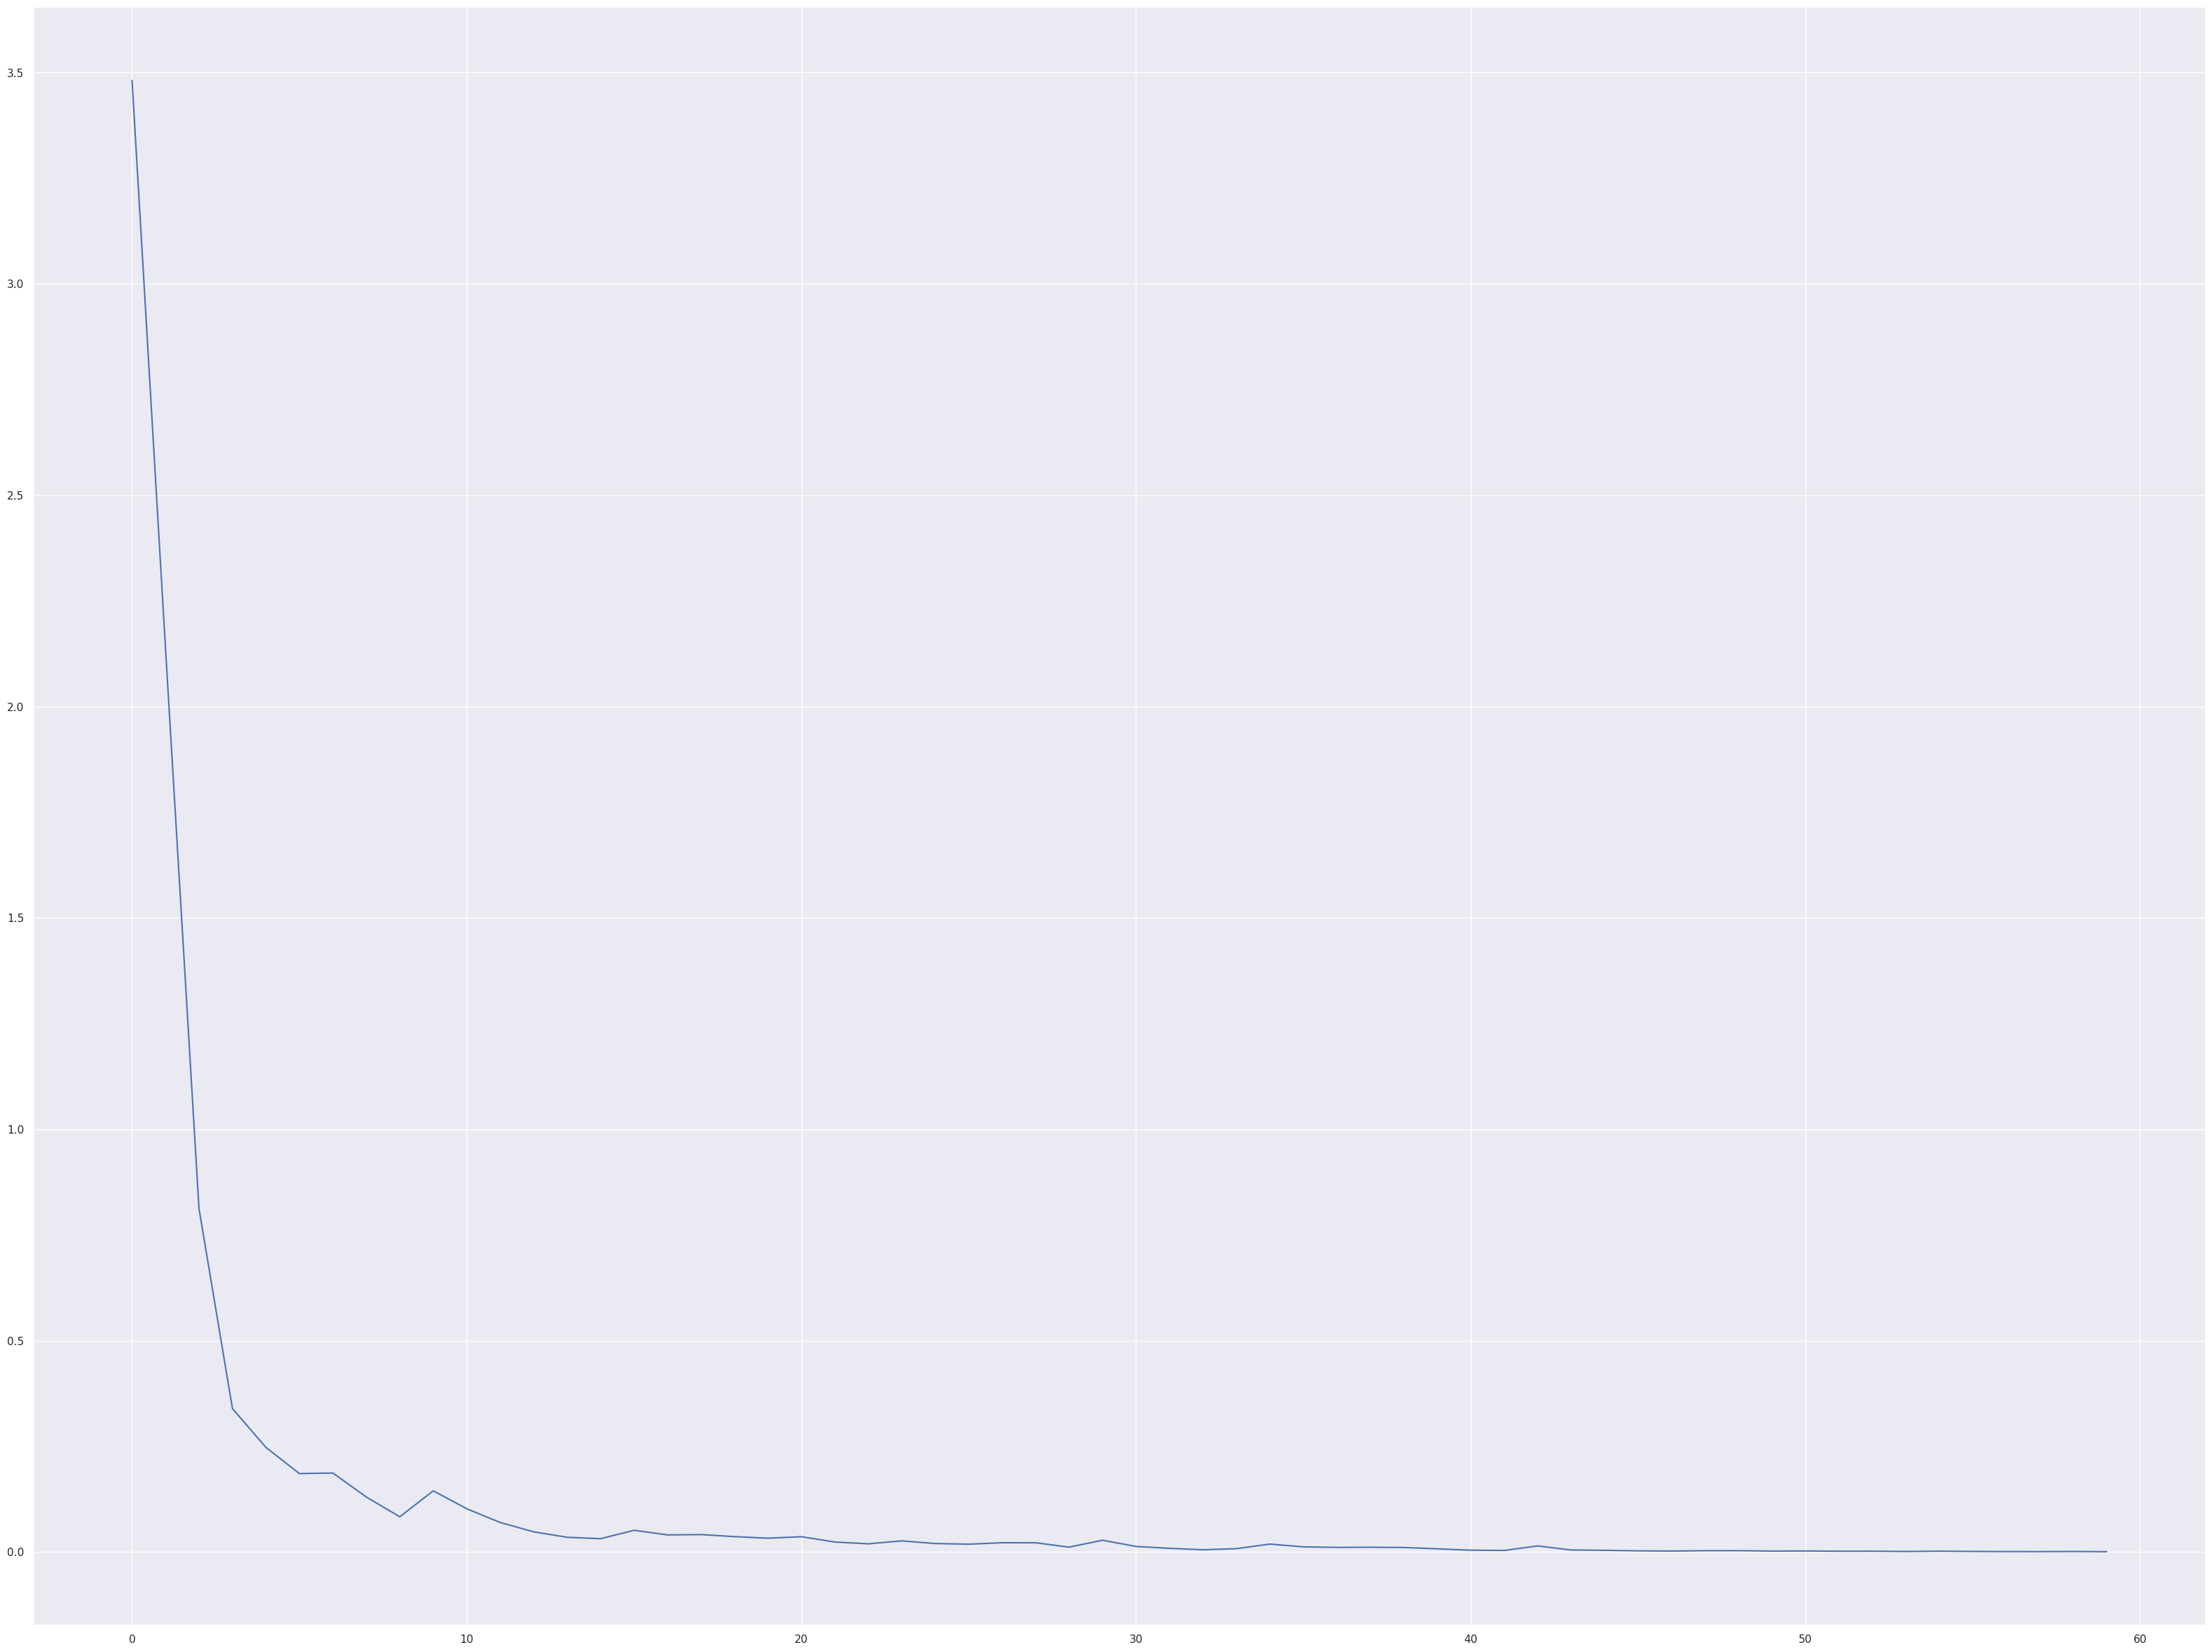

In [183]:
import matplotlib.pyplot as plt
plt.plot(train_losses)

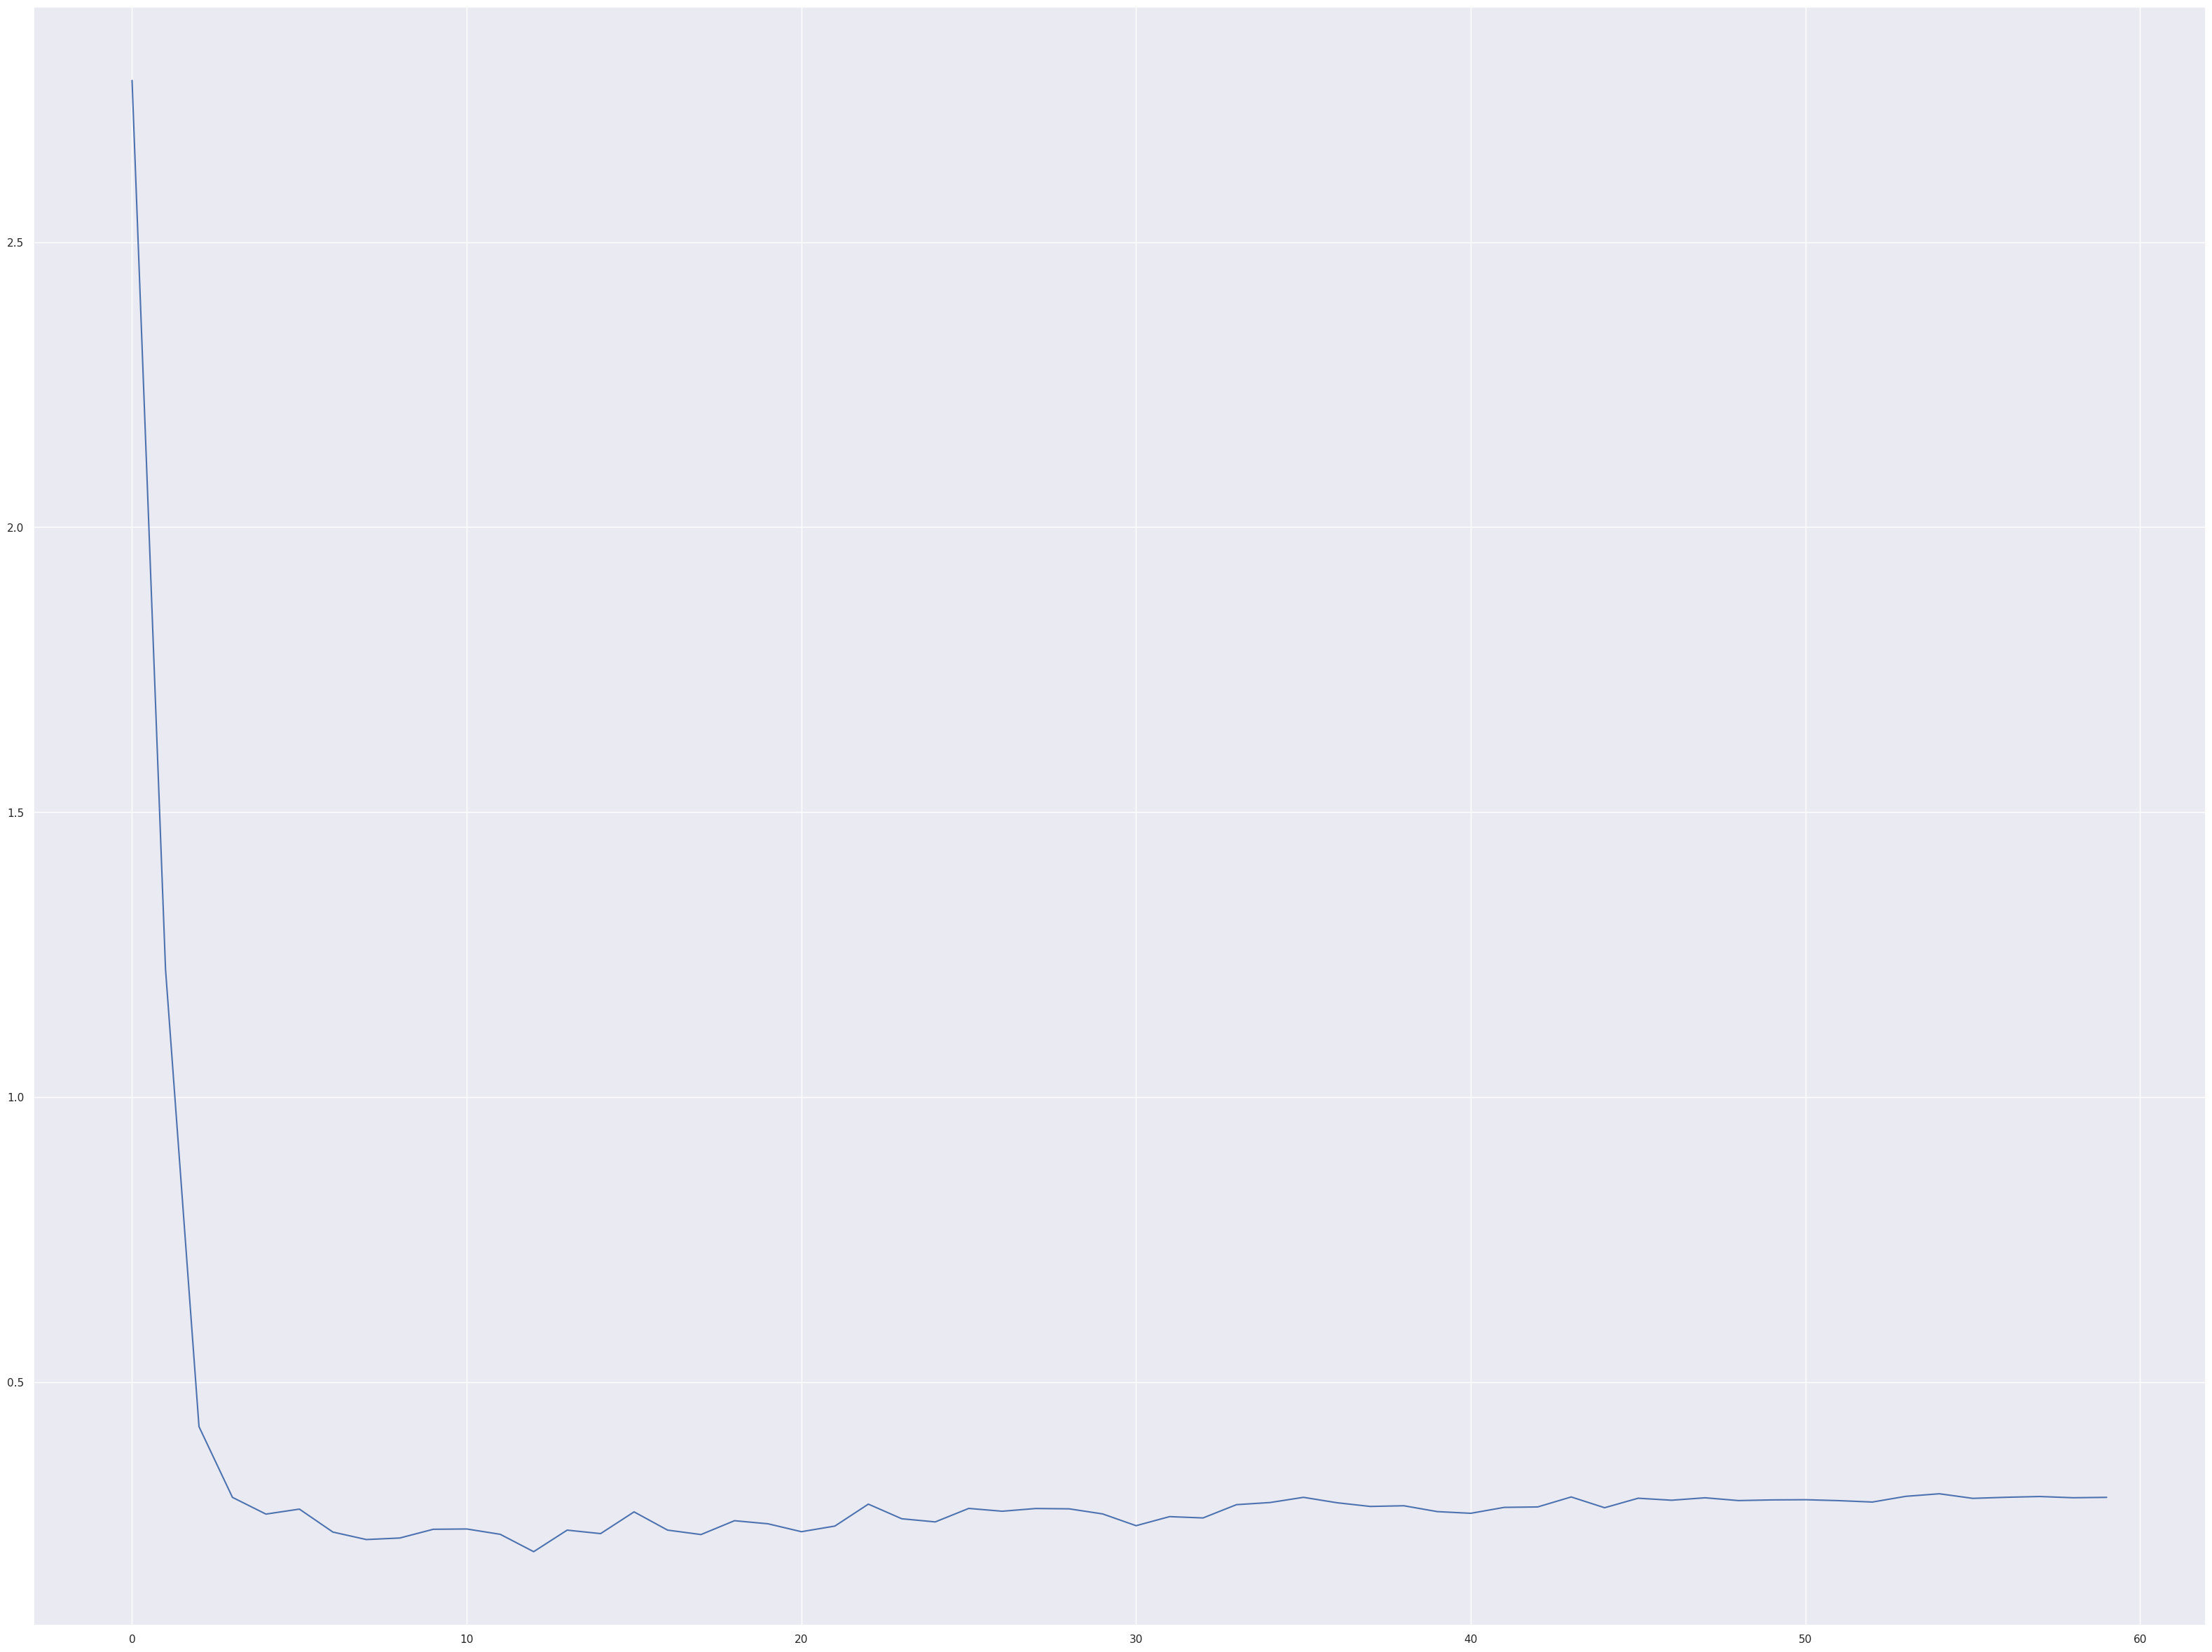

In [184]:
plt.plot(valid_losses)

In [185]:
# torch.save(model.state_dict(), 'models/xlmlarge_149intent_133slot_pytorch_weights_88.pt')

### Load Saved Model

In [8]:
# load weights of best model
path = f'models/xlmLarge_saminF_0621_FOLD10.pt'
print(path)
model.load_state_dict(torch.load(path))

models/xlmLarge_saminF_0621_FOLD10.pt


NameError: name 'model' is not defined

# Inference

In [189]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score, classification_report

evaluate on validation dataset


In [190]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score, classification_report

valid_loss, preds_intent_valid, preds_slot_valid = evaluate(valid_dataloader)

y_pred_intent = np.argmax(preds_intent_valid, axis = 1)
y_true_intent = valid_label_intent
print('Intent:')
print( 'f1_score_macro:',f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='macro'))
print( 'f1_score_micro:',f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='micro'))
print( 'accuracy_score:',accuracy_score(y_true=y_true_intent, y_pred=y_pred_intent))
print( 'f1_weighted_average:',f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='weighted'))
print( 'precision_macro:', precision_score(y_true=y_true_intent, y_pred=y_pred_intent, average = 'macro'))
print( 'recall_macro:', recall_score(y_true=y_true_intent, y_pred=y_pred_intent, average = 'macro'))

y_pred_slot = np.argmax(preds_slot_valid, axis = 2).flatten()
y_true_slot = valid_label_slot.view(-1)
y_true_slot, y_pred_slot = delete_100(y_true_slot.tolist(), y_pred_slot.tolist())
# print('y_true_slot: ',[slot_id2label[i] for i in y_true_slot[:100]], '\ny_pred_slot: ' ,[slot_id2label[i] for i in y_pred_slot[:100]])
print('Slot:')
print( 'f1_score_macro:',f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='macro'))
print( 'f1_score_micro:',f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='micro'))
print( 'accuracy_score:',accuracy_score(y_true=y_true_slot, y_pred=y_pred_slot))
print( 'f1_weighted_average:',f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='weighted'))
print( 'precision_macro:', precision_score(y_true=y_true_slot, y_pred=y_pred_slot, average = 'macro'))
print( 'recall_macro:', recall_score(y_true=y_true_slot, y_pred=y_pred_slot, average = 'macro'))

Intent:
f1_score_macro: 0.9251514960238858
f1_score_micro: 0.9619941873463
accuracy_score: 0.9619941873463
f1_weighted_average: 0.9622635807829895
precision_macro: 0.9286605266424328
recall_macro: 0.9294066003457763
Slot:
f1_score_macro: 0.95439671943052
f1_score_micro: 0.997368499745821
accuracy_score: 0.997368499745821
f1_weighted_average: 0.9973191784055602
precision_macro: 0.9632216162775573
recall_macro: 0.9513972194555038


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [191]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score, classification_report

valid_loss, preds_intent_valid, preds_slot_valid = evaluate(valid_dataloader)

y_pred_intent = np.argmax(preds_intent_valid, axis = 1)
y_true_intent = valid_label_intent
print('Intent:')
print( 'f1_score_macro:',f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='macro'))
print( 'f1_score_micro:',f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='micro'))
print( 'accuracy_score:',accuracy_score(y_true=y_true_intent, y_pred=y_pred_intent))
print( 'f1_weighted_average:',f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='weighted'))
print( 'precision_macro:', precision_score(y_true=y_true_intent, y_pred=y_pred_intent, average = 'macro'))
print( 'recall_macro:', recall_score(y_true=y_true_intent, y_pred=y_pred_intent, average = 'macro'))

y_pred_slot = np.argmax(preds_slot_valid, axis = 2).flatten()
y_true_slot = valid_label_slot.view(-1)
y_true_slot, y_pred_slot = delete_100(y_true_slot.tolist(), y_pred_slot.tolist())

# token-level
print('Slot token-level:')
print( 'f1_score_macro:',f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='macro'))
print( 'f1_score_micro:',f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='micro'))
print( 'fscore_micro_without_o:',fscore_micro_without_o(y_true_slot, y_pred_slot))
print( 'accuracy_score:',accuracy_score(y_true=y_true_slot, y_pred=y_pred_slot))


# phrase-level micro:
# recall_strict
y_true_slot_p_recall, y_pred_slot_p_recall = delete_200(i_to_200(y_true_slot), i_to_200(y_pred_slot))
y_true_slot_p_recall, y_pred_slot_p_recall = delete_134(i_to_200(y_true_slot_p_recall), i_to_200(y_pred_slot_p_recall))
# precision_strict
y_pred_slot_p_precision, y_true_slot_p_precision = delete_200(i_to_200(y_pred_slot), i_to_200(y_true_slot))
y_pred_slot_p_precision, y_true_slot_p_precision = delete_134(i_to_200(y_pred_slot_p_precision), i_to_200(y_true_slot_p_precision))
p = precision_score(y_true=y_true_slot_p_precision, y_pred=y_pred_slot_p_precision, average = 'micro')
r = recall_score(y_true=y_true_slot_p_recall, y_pred=y_pred_slot_p_recall, average = 'micro')
print('Slot phrase-level:')
print( 'f1_micro_phrasal_slot:',(2*p*r)/(p+r))
print( 'precision_micro_phrasal_slot:',p)
print( 'recall_micro_phrasal_slot:',r)

Intent:
f1_score_macro: 0.9251514960238858
f1_score_micro: 0.9619941873463
accuracy_score: 0.9619941873463
f1_weighted_average: 0.9622635807829895
precision_macro: 0.9286605266424328
recall_macro: 0.9294066003457763
Slot token-level:
f1_score_macro: 0.95439671943052
f1_score_micro: 0.997368499745821
fscore_micro_without_o: 0.9869556909429587
accuracy_score: 0.997368499745821
Slot phrase-level:
f1_micro_phrasal_slot: 0.9973541640418294
precision_micro_phrasal_slot: 0.9973227503228448
recall_micro_phrasal_slot: 0.9973855797398179


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [192]:
len(test_dataloader)*128

4992

evaluate on test dataset

In [193]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score, classification_report

valid_loss, preds_intent_valid, preds_slot_valid = evaluate(test_dataloader)

y_pred_intent = np.argmax(preds_intent_valid, axis = 1)
y_true_intent = test_label_intent
print('Intent:')
print( 'f1_score_macro:',f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='macro'))
print( 'f1_score_micro:',f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='micro'))
print( 'accuracy_score:',accuracy_score(y_true=y_true_intent, y_pred=y_pred_intent))
print( 'f1_weighted_average:',f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='weighted'))
print( 'precision_macro:', precision_score(y_true=y_true_intent, y_pred=y_pred_intent, average = 'macro'))
print( 'recall_macro:', recall_score(y_true=y_true_intent, y_pred=y_pred_intent, average = 'macro'))

y_pred_slot = np.argmax(preds_slot_valid, axis = 2).flatten()
y_true_slot = test_label_slot.view(-1)
y_true_slot, y_pred_slot = delete_100(y_true_slot.tolist(), y_pred_slot.tolist())
# print('y_true_slot: ',[slot_id2label[i] for i in y_true_slot[:100]], '\ny_pred_slot: ' ,[slot_id2label[i] for i in y_pred_slot[:100]])
print('Slot:')
print( 'f1_score_macro:',f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='macro'))
print( 'f1_score_micro:',f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='micro'))
print( 'accuracy_score:',accuracy_score(y_true=y_true_slot, y_pred=y_pred_slot))
print( 'f1_weighted_average:',f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='weighted'))
print( 'precision_macro:', precision_score(y_true=y_true_slot, y_pred=y_pred_slot, average = 'macro'))
print( 'recall_macro:', recall_score(y_true=y_true_slot, y_pred=y_pred_slot, average = 'macro'))

Intent:
f1_score_macro: 0.9359021190330841
f1_score_micro: 0.9621654256389616
accuracy_score: 0.9621654256389616
f1_weighted_average: 0.9625612805651413
precision_macro: 0.934262049637036
recall_macro: 0.9429409331805498
Slot:
f1_score_macro: 0.9281747118829133
f1_score_micro: 0.9958870007576578
accuracy_score: 0.9958870007576578
f1_weighted_average: 0.995891091066645
precision_macro: 0.9259436008033962
recall_macro: 0.9352188544193776


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [201]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score, classification_report

valid_loss, preds_intent_valid, preds_slot_valid = evaluate(test_dataloader)

y_pred_intent = np.argmax(preds_intent_valid, axis = 1)
y_true_intent = test_label_intent
print('Intent:')
print( 'f1_score_macro:',f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='macro'))
print( 'f1_score_micro:',f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='micro'))
print( 'accuracy_score:',accuracy_score(y_true=y_true_intent, y_pred=y_pred_intent))
print( 'f1_weighted_average:',f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='weighted'))
print( 'precision_macro:', precision_score(y_true=y_true_intent, y_pred=y_pred_intent, average = 'macro'))
print( 'recall_macro:', recall_score(y_true=y_true_intent, y_pred=y_pred_intent, average = 'macro'))

y_pred_slot = np.argmax(preds_slot_valid, axis = 2).flatten()
y_true_slot = test_label_slot.view(-1)
y_true_slot, y_pred_slot = delete_100(y_true_slot.tolist(), y_pred_slot.tolist())

# token-level
print('Slot token-level:')
print( 'f1_score_macro:',f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='macro'))
print( 'f1_score_micro:',f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='micro'))
print( 'fscore_micro_without_o:',fscore_micro_without_o(y_true_slot, y_pred_slot))
print( 'accuracy_score:',accuracy_score(y_true=y_true_slot, y_pred=y_pred_slot))


# phrase-level micro:
# recall_strict
y_true_slot_p_recall, y_pred_slot_p_recall = delete_200(i_to_200(y_true_slot), i_to_200(y_pred_slot))
y_true_slot_p_recall, y_pred_slot_p_recall = delete_134(i_to_200(y_true_slot_p_recall), i_to_200(y_pred_slot_p_recall))
# precision_strict
y_pred_slot_p_precision, y_true_slot_p_precision = delete_200(i_to_200(y_pred_slot), i_to_200(y_true_slot))
y_pred_slot_p_precision, y_true_slot_p_precision = delete_134(i_to_200(y_pred_slot_p_precision), i_to_200(y_true_slot_p_precision))
p = precision_score(y_true=y_true_slot_p_precision, y_pred=y_pred_slot_p_precision, average = 'micro')
r = recall_score(y_true=y_true_slot_p_recall, y_pred=y_pred_slot_p_recall, average = 'micro')
print('Slot phrase-level:')
print( 'f1_micro_phrasal_slot:',(2*p*r)/(p+r))
print( 'precision_micro_phrasal_slot:',p)
print( 'recall_micro_phrasal_slot:',r)

Intent:
f1_score_macro: 0.9359021190330841
f1_score_micro: 0.9621654256389616
accuracy_score: 0.9621654256389616
f1_weighted_average: 0.9625612805651413
precision_macro: 0.934262049637036
recall_macro: 0.9429409331805498
Slot token-level:
f1_score_macro: 0.9281747118829133
f1_score_micro: 0.9958870007576578
fscore_micro_without_o: 0.9786251492332569
accuracy_score: 0.9958870007576578
Slot phrase-level:
f1_micro_phrasal_slot: 0.9957708900999092
precision_micro_phrasal_slot: 0.9957991541540121
recall_micro_phrasal_slot: 0.9957426276502143


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_

# Classification reports

## intent confusion matrix

In [202]:
# sorted([intent_label2id[i] for i in test_df['intent_label'].unique()])

In [203]:
# xlm-large with 149 intent label
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true=y_true_intent , y_pred=y_pred_intent
                            # ,labels = range(len(intent_id2label))
                            ,target_names =[intent_id2label[int(i)] for i in (list(classification_report(y_true=y_true_intent , y_pred=y_pred_intent, output_dict=True).keys())[:-3])],
                            digits=4))

                             precision    recall  f1-score   support

                   AI_human     1.0000    1.0000    1.0000        10
                       adie     0.9750    0.9512    0.9630        41
           another_question     1.0000    1.0000    1.0000         8
         answer_my_question     1.0000    1.0000    1.0000        11
              appraisal_bad     0.6667    0.9231    0.7742        13
             appraisal_good     0.9091    0.6667    0.7692        15
        appraisal_noproblem     0.8333    0.7143    0.7692         7
                are_u_there     1.0000    0.6250    0.7692         8
                   ask_azan     1.0000    1.0000    1.0000        70
        ask_bot_personality     0.8571    0.6667    0.7500         9
        ask_bot_socialmedia     1.0000    0.9333    0.9655        15
           ask_bot_to _joke     0.8333    1.0000    0.9091        10
     ask_bot_to_say_memento     1.0000    1.0000    1.0000         9
                 ask_botage     1

In [204]:
intent_classification_report = classification_report(y_true=y_true_intent , y_pred=y_pred_intent
                            # ,labels = range(len(intent_id2label))
                            ,target_names =[intent_id2label[int(i)] for i in (list(classification_report(y_true=y_true_intent , y_pred=y_pred_intent, output_dict=True).keys())[:-3])] ,output_dict=True , digits=4)

df_intent_classification_report = pd.DataFrame(intent_classification_report).transpose()
df_intent_classification_report

,precision,recall,f1-score,support
AI_human,1.000000,1.000000,1.000000,10.000000
adie,0.975000,0.951220,0.962963,41.000000
another_question,1.000000,1.000000,1.000000,8.000000
answer_my_question,1.000000,1.000000,1.000000,11.000000
appraisal_bad,0.666667,0.923077,0.774194,13.000000
...,...,...,...,...
word_meaning,1.000000,1.000000,1.000000,71.000000
zekr,0.916667,1.000000,0.956522,11.000000
accuracy,0.962165,0.962165,0.962165,0.962165
macro avg,0.934262,0.942941,0.935902,4969.000000


In [205]:
# df_intent_classification_report.to_excel('reports/intent_classification_report_for_just_intent_with_slots_0704.xlsx')
print(f'reports/intent_classification_report_for_xlmLarge_saminF_0621_FOLD10.xlsx')
df_intent_classification_report.to_excel(f'reports/intent_classification_report_for_175intent(800oos_2offensiveAs1)_132slot_{DATE}_FOLD{FOLD+1}.xlsx')

reports/intent_classification_report_for_xlmLarge_saminF_0621_FOLD10.xlsx


confusion matrix

In [206]:
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
len(confusion_matrix(y_true=y_true_intent , y_pred=y_pred_intent ))

177

In [207]:
train_df.intent_label.value_counts()

intent_label
offensive            6267
oos                  2480
user_introduce        809
ask_azan              760
city_population       637
                     ... 
khaste_nabashid        46
user_ask_season        43
dialog_hold_on         40
high_five              39
tehran_metro_info      37
Name: count, Length: 177, dtype: int64

In [208]:
df[df.intent == 'ask_math'] #'esm_famil' 'translate_it' 'sheer'  'ask_math'

,pattern_id,text,slots,intent
2476,966,تو که ریاضیت خوبه جواب تقسیم 16 بر 25157 رو می...,o o o o o b-divide b-num1 o b-num2 o o o o o o,ask_math
2477,967,آیا این امکان برای شما هست که بمن جواب تقسیم 8...,o o o o o o o o o b-divide b-num1 o b-num2 o o,ask_math
2478,968,ریاضیم خیلی ضعیفه یه کمکی بهم میکنی 86 رو بر 1...,o o o o o o o b-num1 o o b-num2 b-divide o o o...,ask_math
2479,969,بیا یه امتحان ریاضی بگیرم ازت ببینم چقدر بارته...,o o o o o o o o o b-num1 o b-divide o o b-num2,ask_math
2480,970,میتونی بهم بگی اگه 64 رو بر 907482 تقسیم کنیم ...,o o o o b-num1 o o b-num2 b-divide o o o o o o,ask_math
...,...,...,...,...
3150,1222,ریاضیدان بلدی برام یه جذر بگیری,o o o o b-redical o,ask_math
3151,1223,مخ ریاضی رادیکال 25 را بگیرید,o o b-redical b-num1 o o,ask_math
3152,1224,شنیدم مخ ریاضی هم هستی. میتونی رادیکال بگیری؟,o o o o o o b-redical o,ask_math
3153,1225,میتونی جمع دو تا عدد رو بزنی؟,o b-plus o o o o o,ask_math


In [209]:
df.intent.unique()

array(['adie', 'ask_azan', 'ask_capital', 'ask_currency', 'ask_math',
       'ask_restaurant', 'ask_sendpic', 'ask_time', 'ask_weather',
       'ask_what_to_cook', 'birth_things', 'book_info', 'bot_favorites',
       'calendar_convert', 'city_distance', 'city_population',
       'city_sightseeing', 'complaints', 'convert_currency',
       'create_password', 'danestani', 'dictation', 'esm_famil', 'fal',
       'find_cinama', 'get_cooktime', 'get_food_energy',
       'get_food_nutrition', 'get_ingredients', 'get_recipe', 'moshaereh',
       'movie_genre', 'movie_info', 'movie_score', 'movie_show_time',
       'nahjolbalaghe', 'next_event_date', 'president', 'quran_info',
       'sheer', 'sing_a_song', 'tasadofi', 'telephone', 'todate_is',
       'translate_it', 'unit_convert', 'user_introduce', 'where_to_go',
       'word_meaning', 'zekr', 'price_gold', 'ask_botname',
       'user_needs_help', 'ask_botjob', 'good_evening', 'good_morning',
       'good_night', 'nice_to_meet_you', 'ask_how

In [210]:
labels=[intent_id2label[int(i)] for i in (list(classification_report(y_true=y_true_intent , y_pred=y_pred_intent, output_dict=True).keys())[:-3])]
len(labels)

177

In [211]:
cm = confusion_matrix(y_true=y_true_intent , y_pred=y_pred_intent )
df_intent_confusion_matrix = pd.DataFrame(cm,columns=labels, index=labels)
print(f'reports/intent_confusion_matrix_0621_FOLD{FOLD+1}.xlsx')
df_intent_confusion_matrix .to_excel(f'reports/intent_confusion_matrix_{DATE}_FOLD{FOLD+1}.xlsx')

reports/intent_confusion_matrix_0621_FOLD10.xlsx


In [212]:
len(df_intent_confusion_matrix.columns)

177

In [213]:
len(df_intent_confusion_matrix)

177

In [214]:
confusion_list = []
for i in range(len(df_intent_confusion_matrix)):
    for j in range(len(df_intent_confusion_matrix.columns)):
        if i == j :
            continue
        if df_intent_confusion_matrix.iloc[i][j] != 0 :
            confusion_list.append([df_intent_confusion_matrix.index[i], df_intent_confusion_matrix.columns[j], df_intent_confusion_matrix.iloc[i][j]])

confusion_matrix_limited = pd.DataFrame(confusion_list, columns=['gold','pred','mismatch counts']).sort_values(['mismatch counts'],ascending=False)
print(f'reports/intent_confusion_matrix_limited_0621_FOLD{FOLD+1}.xlsx')
confusion_matrix_limited.to_excel(f'reports/intent_confusion_matrix_limited_0621_FOLD{FOLD+1}.xlsx')
confusion_matrix_limited

/tmp/ipykernel_1666/3926923452.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df_intent_confusion_matrix.iloc[i][j] != 0 :
/tmp/ipykernel_1666/3926923452.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  confusion_list.append([df_intent_confusion_matrix.index[i], df_intent_confusion_matrix.columns[j], df_intent_confusion_matrix.iloc[i][j]])


reports/intent_confusion_matrix_limited_0621_FOLD10.xlsx


,gold,pred,mismatch counts
28,ask_what_to_cook,get_recipe,6
36,city_sightseeing,where_to_go,5
81,offensive,user_angry,4
63,offensive,appraisal_bad,4
95,sheer,danestani,4
...,...,...,...
62,no_money,offensive,1
61,no_money,fal,1
60,movie_genre,movie_info,1
59,investment_money,oos,1


In [215]:
df_intent_confusion_matrix.iloc[1][2]

/tmp/ipykernel_1666/1103776650.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_intent_confusion_matrix.iloc[1][2]


0

In [216]:

df_intent_confusion_matrix.index[3]

'answer_my_question'

In [217]:
df_intent_confusion_matrix.columns[3]

'answer_my_question'

In [218]:
len(intent_id2label)

177

In [219]:
# confusion_matrix(y_true=y_true_intent , y_pred=y_pred_intent , labels=[intent_id2label[int(i)] for i in (list(classification_report(y_true=y_true_intent , y_pred=y_pred_intent, output_dict=True).keys())[:-3])])

In [220]:
# [intent_id2label[int(i)] for i in (list(classification_report(y_true=y_true_intent , y_pred=y_pred_intent, output_dict=True).keys())[:-3])]

In [221]:
# cm = confusion_matrix(y_true=y_true_intent , y_pred=y_pred_intent , labels=[intent_id2label[int(i)] for i in (list(classification_report(y_true=y_true_intent , y_pred=y_pred_intent, output_dict=True).keys())[:-3])] )

In [222]:
# disp = ConfusionMatrixDisplay(confusion_matrix(y_true=y_true_intent , y_pred=y_pred_intent) , display_labels=[intent_id2label[int(i)] for i in (list(classification_report(y_true=y_true_intent , y_pred=y_pred_intent, output_dict=True).keys())[:-3])] )
# disp.plot()
# plt.show()

## slot confusion matrix

In [223]:
# xlm-large with 133 slot label
from sklearn.metrics import classification_report
print(classification_report(y_true=y_true_slot , y_pred=y_pred_slot
                            # ,labels = range(len(slot_label2id))
                            ,target_names =[slot_id2label[int(i)] for i in (list(classification_report(y_true=y_true_slot , y_pred=y_pred_slot, output_dict=True).keys())[:-3])],
                            digits=4))

                        precision    recall  f1-score   support

            b-alphabet     1.0000    0.9643    0.9818        28
           b-book_name     0.9831    0.9667    0.9748        60
              b-cinema     1.0000    1.0000    1.0000        18
                b-city     0.9864    1.0000    0.9932       291
           b-coin_type     1.0000    1.0000    1.0000        67
   b-complaint_subject     1.0000    1.0000    1.0000        54
             b-country     0.9882    1.0000    0.9940       167
            b-currency     0.9899    0.9899    0.9899        99
           b-d_subject     0.9535    0.9762    0.9647        42
                b-date     0.9812    0.9248    0.9522       226
                 b-day     0.6154    1.0000    0.7619         8
       b-dest_calender     1.0000    0.9730    0.9863        74
           b-dest_city     0.9773    1.0000    0.9885        43
       b-dest_currency     0.9737    1.0000    0.9867        37
b-destination_language     0.9818    0.

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_

In [224]:
slot_classification_report = classification_report(y_true=y_true_slot , y_pred=y_pred_slot
                            # ,labels = range(len(slot_label2id))
                            ,target_names =[slot_id2label[int(i)] for i in (list(classification_report(y_true=y_true_slot , y_pred=y_pred_slot, output_dict=True).keys())[:-3])] ,output_dict=True, digits=4 )

df_slot_classification_report = pd.DataFrame(slot_classification_report).transpose()
df_slot_classification_report

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_

,precision,recall,f1-score,support
b-alphabet,1.000000,0.964286,0.981818,28.000000
b-book_name,0.983051,0.966667,0.974790,60.000000
b-cinema,1.000000,1.000000,1.000000,18.000000
b-city,0.986441,1.000000,0.993174,291.000000
b-coin_type,1.000000,1.000000,1.000000,67.000000
...,...,...,...,...
i-word,1.000000,1.000000,1.000000,15.000000
o,0.998838,0.998462,0.998650,31864.000000
accuracy,0.995887,0.995887,0.995887,0.995887
macro avg,0.925944,0.935219,0.928175,36956.000000


In [226]:
print(f'reports/slot_classification_report_for_saminF_0621_FOLD{FOLD+1}.xlsx')
df_slot_classification_report.to_excel(f'reports/slot_classification_report_for_175intent(800oos_2offensiveAs1)_132slot_{DATE}_FOLD{FOLD+1}.xlsx')

reports/slot_classification_report_for_saminF_0621_FOLD10.xlsx


## test on intents with slots

In [228]:
test_df = df[df["pattern_id"].isin(test_patterns)]
test_df = test_df [ test_df['pattern_id']< 2_000_000]

test_text = test_df["text"]
test_intent_label = test_df["intent"]
test_slot_label = test_df["slots"]

test_text = test_text.values
test_intent_label = test_intent_label.values
test_slot_label = test_slot_label.values
#############################################################################

import pandas as pd
import numpy as np

def process_dataset(text_dataset, intent_label_dataset, slot_label_dataset):
    output_dataset = list()
    for i in range(len(intent_label_dataset)):
        slot_tokens = []
        slot_labels = []

        for token, token_label in zip(text_dataset[i].split(" "), slot_label_dataset[i].split(" ")):
            slot_tokens.append(token)
            slot_labels.append(token_label)

        output_dataset.append({"text": text_dataset[i],
                               "intent_label": intent_label_dataset[i],
                               "slot_tokens": slot_tokens,
                               "slot_labels": slot_labels})

    return pd.DataFrame(output_dataset)

test_df = process_dataset(test_text, test_intent_label, test_slot_label)
#############################################################################

MAX_SEQ_LEN = 64

def tokenize_and_align_labels(examples, slot_label2id=slot_label2id, intent_label2id=intent_label2id):
    tokenized_inputs = tokenizer(examples["slot_tokens"],truncation=True, padding="max_length", max_length=MAX_SEQ_LEN,
                               is_split_into_words=True, return_token_type_ids=False)

    slot_labels = []
    intent_label = []
    for i, label in enumerate(examples["slot_labels"]):
        word_ids = tokenized_inputs.word_ids()
        previous_word_id = None
        label_ids = []
        for word_id in word_ids:  # Set the special tokens to 0.
            if word_id is None: # Special tokens have a word id "None". We set the label to -100 so they are automatically ignored in the loss function.
                label_ids.append(-100)
            elif word_id != previous_word_id: # We set the label for the first token of each word.
                label_ids.append(slot_label2id[examples["slot_labels"][word_id]])
            else:  # For the other tokens in a word, we set the label to either the current label or -100, depending on the label_all_tokens flag.
                # label_ids.append(label[word_idx] if label_all_tokens else -100)
                label_ids.append(-100)
            previous_word_id = word_id

        slot_labels.append(label_ids)
        intent_label.append(intent_label2id[examples["intent_label"]])
    tokenized_inputs["slot_labels"] = slot_labels[0]
    tokenized_inputs["intent_label"] = intent_label[0]
    # x, y_slot, y_intent
    return tokenized_inputs['input_ids'], tokenized_inputs['attention_mask'], tokenized_inputs['slot_labels'], tokenized_inputs['intent_label']

tokenized_test = {'input_ids':[], 'attention_mask':[], 'slot_labels':[], 'intent_label':[]}
for i in tqdm(range(len(test_df))):
    tokenized_test['input_ids'].append(tokenize_and_align_labels(test_df.iloc[i])[0])
    tokenized_test['attention_mask'].append(tokenize_and_align_labels(test_df.iloc[i])[1])
    tokenized_test['slot_labels'].append(tokenize_and_align_labels(test_df.iloc[i])[2])
    tokenized_test['intent_label'].append(tokenize_and_align_labels(test_df.iloc[i])[3])
#############################################################################

# # for test set
test_input_ids = torch.tensor(tokenized_test['input_ids'])
test_attention_mask = torch.tensor(tokenized_test['attention_mask'])
test_label_intent = torch.tensor(tokenized_test['intent_label'])
test_label_slot = torch.tensor(tokenized_test['slot_labels'])
#############################################################################

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
BATCH_SIZE = 128
test_data = TensorDataset(test_input_ids, test_attention_mask, test_label_intent, test_label_slot)
test_sampler = SequentialSampler(test_data)
test_dataloader_just_intents_with_slots = DataLoader(test_data, sampler = test_sampler, batch_size=BATCH_SIZE)

NameError: name 'test_patterns' is not defined

In [229]:
len(test_dataloader)

39

In [230]:
len(test_dataloader_just_intents_with_slots)

NameError: name 'test_dataloader_just_intents_with_slots' is not defined

In [231]:
valid_loss, preds_intent_valid, preds_slot_valid = evaluate(test_dataloader_just_intents_with_slots)

y_pred_intent = np.argmax(preds_intent_valid, axis = 1)
y_true_intent = test_label_intent
print('Intent:')
print( 'f1_score_macro:',f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='macro'))
print( 'f1_score_micro:',f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='micro'))
print( 'accuracy_score:',accuracy_score(y_true=y_true_intent, y_pred=y_pred_intent))
print( 'f1_weighted_average:',f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='weighted'))
print( 'precision_macro:', precision_score(y_true=y_true_intent, y_pred=y_pred_intent, average = 'macro'))
print( 'recall_macro:', recall_score(y_true=y_true_intent, y_pred=y_pred_intent, average = 'macro'))

y_pred_slot = np.argmax(preds_slot_valid, axis = 2).flatten()
y_true_slot = test_label_slot.view(-1)
y_true_slot, y_pred_slot = delete_100(y_true_slot.tolist(), y_pred_slot.tolist())  # for words
# y_true_slot_w, y_pred_slot_w = delete_100(y_true_slot.tolist(), y_pred_slot.tolist())
y_true_slot_p, y_pred_slot_p = delete_200(i_to_200(y_true_slot), i_to_200(y_pred_slot))  # for phrases
# print('y_true_slot: ',[slot_id2label[i] for i in y_true_slot[:100]], '\ny_pred_slot: ' ,[slot_id2label[i] for i in y_pred_slot[:100]])
print('Slot:')
print( 'f1_score_macro:',f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='macro'))
print( 'f1_score_micro:',f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='micro'))
print( 'accuracy_score:',accuracy_score(y_true=y_true_slot, y_pred=y_pred_slot))
print( 'f1_weighted_average:',f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='weighted'))
print( 'precision_macro:', precision_score(y_true=y_true_slot, y_pred=y_pred_slot, average = 'macro'))
print( 'recall_macro:', recall_score(y_true=y_true_slot, y_pred=y_pred_slot, average = 'macro'),end="\n\n")
print('Slot Phrasal:')
print( 'f1_score_macro:',f1_score(y_true=y_true_slot_p, y_pred=y_pred_slot_p, average='macro'))
print( 'f1_score_micro:',f1_score(y_true=y_true_slot_p, y_pred=y_pred_slot_p, average='micro'))
print( 'accuracy_score:',accuracy_score(y_true=y_true_slot_p, y_pred=y_pred_slot_p))
print( 'f1_weighted_average:',f1_score(y_true=y_true_slot_p, y_pred=y_pred_slot_p, average='weighted'))
print( 'precision_macro:', precision_score(y_true=y_true_slot_p, y_pred=y_pred_slot_p, average = 'macro'))
print( 'recall_macro:', recall_score(y_true=y_true_slot_p, y_pred=y_pred_slot_p, average = 'macro'))

NameError: name 'test_dataloader_just_intents_with_slots' is not defined

# Buliding output

In [232]:
input_sample = ['هوای مشهد چجوریه'
                ,'قرمه سبزی مامان‌پز میخوام، چیکار کنم؟'
                ,'خیلی گاوی به خدا'
                ,'یک بلیط میخوام'
                ,'بات دیوونه'
                ,'کارت به کارت به علی']
# input_sample = df['text'][230:234]

In [233]:
input_sample = df[df.intent == 'ask_math']['text'].to_list() #'esm_famil' 'translate_it' 'sheer'  'ask_math'

In [234]:
input_slots = df[df.intent == 'ask_math']['slots'].to_list()

In [235]:
def sent_to_slots(astring: str):
    tokenized_inputs = tokenizer(astring.split(), #return_special_tokens_mask =True, #is_split_into_words=True, return_tensors='pt').to('cuda')
                                  truncation=True, padding="max_length", max_length=MAX_SEQ_LEN,
                                  is_split_into_words=True, return_token_type_ids=False, return_tensors='pt').to('cuda')
    intent_prob, slot_prob = model(tokenized_inputs['input_ids'], tokenized_inputs['attention_mask'])
    intent_pred = np.argmax(intent_prob.detach().cpu().numpy(), axis = 1)
    slot_pred = np.argmax(slot_prob.detach().cpu().numpy(), axis = 2)

    word_ids = tokenized_inputs.word_ids()
    # print(len(word_ids),word_ids)
    # print(len(slot_pred_n[0]),slot_pred_n[0])
    previous_word_id = None
    label_ids = []
    for i,word_id in enumerate(word_ids):  # Set the special tokens to 0.
        if word_id is None: # Special tokens have a word id "None". We set the label to -100 so they are automatically ignored in the loss function.
            continue
        elif word_id == previous_word_id: # We set the label for the first token of each word.
            continue
        else:  # For the other tokens in a word, we set the label to either the current label or -100, depending on the label_all_tokens flag.
            # label_ids.append(label[word_idx] if label_all_tokens else -100)
            # print(i)
            label_ids.append(slot_id2label[slot_pred[0][i]])
        previous_word_id = word_id
    # print(astring)
    # print(label_ids)
    # print(intent_id2label[intent_pred[0]])
    return astring  , label_ids , intent_id2label[intent_pred[0]]

In [236]:
pd.DataFrame([sent_to_slots(i) for i in input_sample] , columns=['text','slots','intent'])#.to_excel('ask_math_samples.xlsx')

,text,slots,intent
0,تو که ریاضیت خوبه جواب تقسیم 16 بر 25157 رو می...,"[o, o, o, o, o, b-divide, b-num1, o, b-num2, o...",ask_math
1,آیا این امکان برای شما هست که بمن جواب تقسیم 8...,"[o, o, o, o, o, o, o, o, o, b-divide, b-num1, ...",ask_math
2,ریاضیم خیلی ضعیفه یه کمکی بهم میکنی 86 رو بر 1...,"[o, o, o, o, o, o, o, b-num1, o, o, b-num2, b-...",ask_math
3,بیا یه امتحان ریاضی بگیرم ازت ببینم چقدر بارته...,"[o, o, o, o, o, o, o, o, o, b-num1, o, b-divid...",ask_math
4,میتونی بهم بگی اگه 64 رو بر 907482 تقسیم کنیم ...,"[o, o, o, o, b-num1, o, o, b-num2, b-divide, o...",ask_math
...,...,...,...
674,ریاضیدان بلدی برام یه جذر بگیری,"[o, o, o, o, b-radical, o]",ask_math
675,مخ ریاضی رادیکال 25 را بگیرید,"[o, o, b-redical, b-num1, o, o]",ask_math
676,شنیدم مخ ریاضی هم هستی. میتونی رادیکال بگیری؟,"[o, o, o, o, o, o, b-redical, o]",ask_math
677,میتونی جمع دو تا عدد رو بزنی؟,"[o, b-plus, o, o, o, o, o]",ask_math


In [237]:
pd.concat([pd.DataFrame([sent_to_slots(i) for i in input_sample] , columns=['text','slots','intent']), df[df.intent == 'ask_math']['slots'].reset_index(drop=True), df[df.intent == 'ask_math']['intent'].reset_index(drop=True)],axis=1).to_excel('reports/ask_math_samples.xlsx')

# Old Results

In [ ]:
# All intents
# dataset = df_with_slots + df_without_slots + df_offensive_general + df_oos

from sklearn import metrics
from IPython.display import display,clear_output
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score

# number of training epochs
epochs = EPOCHS

# set initial loss to infinite
best_valid_loss = float('inf')
best_f1_macro_slot = 0

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

f1_macro_intent = []
f1_micro_intent = []
accuracy_intent = []

f1_macro_slot = []
f1_micro_slot = []
accuracy_slot = []

f1_micro_average = []
f1_weighted_average = []
precision = []
recall = []
accuracy = []

for epoch in tqdm(range(epochs), desc="Epochs"):

    # train_loss, preds_train  = train()
    # valid_loss, preds_valid = evaluate()
    train_loss, preds_intent_train, preds_slot_train  = train()
    valid_loss, preds_intent_valid, preds_slot_valid = evaluate()

    # y_pred_train = np.argmax(preds_train, axis = 1)
    y_pred_intent_train = np.argmax(preds_intent_train, axis = 1)
    y_pred_slot_train = np.argmax(preds_slot_train, axis = 2)

    # y_pred = np.argmax(preds_valid, axis = 1)
    y_pred_intent = np.argmax(preds_intent_valid, axis = 1)
    y_true_intent = valid_label_intent
    f1_macro_intent.append( f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='macro'))
    f1_micro_intent.append( f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='micro'))
    accuracy_intent.append( accuracy_score(y_true=y_true_intent, y_pred=y_pred_intent))

    y_pred_slot = np.argmax(preds_slot_valid, axis = 2).flatten()
    y_true_slot = valid_label_slot.view(-1)
    y_true_slot, y_pred_slot = delete_100(y_true_slot.tolist(), y_pred_slot.tolist())
    # print('y_true_slot: ',[slot_id2label[i] for i in y_true_slot[:100]], '\ny_pred_slot: ' ,[slot_id2label[i] for i in y_pred_slot[:100]])
    f1_macro_slot.append( f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='macro'))
    f1_micro_slot.append( f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='micro'))
    accuracy_slot.append( accuracy_score(y_true=y_true_slot, y_pred=y_pred_slot))


    # f1_weighted_average.append( f1_score(y_true=y_true, y_pred=y_pred, average='weighted'))
    # precision.append( precision_score(y_true, y_pred, average = 'macro'))
    # recall.append( recall_score(y_true, y_pred, average = 'macro'))

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    df_results = pd.DataFrame({'Training Loss': train_losses,  'Validation Loss': valid_losses,
                       'Intent F1 Macro':f1_macro_intent,'Intent F1 Micro':f1_micro_intent,'Intent Accuracy':accuracy_intent,
                      'Slot F1 Macro':f1_macro_slot,'Slot F1 Micro':f1_micro_slot,'Slot Accuracy':accuracy_slot})
    df_results.index += 1; df_results.index.name='epoch'
    clear_output(wait=True)
    display(df_results)

    if f1_macro_slot[-1] > best_f1_macro_slot:
        best_f1_macro_slot = f1_macro_slot[-1]
        torch.save(model.state_dict(), 'models/xlmlarge_174intent(with_oos)_135slot_pytorch_weights_0709.pt')

,Training Loss,Validation Loss,Intent F1 Macro,Intent F1 Micro,Intent Accuracy,Slot F1 Macro,Slot F1 Micro,Slot Accuracy
epoch,,,,,,,,
1,3.050600,2.334823,0.156286,0.719820,0.719820,0.009564,0.970589,0.970589
2,1.879603,0.527558,0.536680,0.870021,0.870021,0.062682,0.976511,0.976511
3,0.834439,0.416132,0.665734,0.880010,0.880010,0.159333,0.982151,0.982151
4,0.469004,0.246260,0.720601,0.911560,0.911560,0.214941,0.983921,0.983921
5,0.367903,0.237077,0.688807,0.913510,0.913510,0.241546,0.984533,0.984533
6,0.343668,0.325434,0.703094,0.873432,0.873432,0.237077,0.983971,0.983971
7,0.336704,0.196335,0.743758,0.928249,0.928249,0.390487,0.988189,0.988189
8,0.288221,0.191017,0.744650,0.930442,0.930442,0.413859,0.989810,0.989810
9,0.218367,0.177891,0.785060,0.937142,0.937142,0.476653,0.991398,0.991398


In [ ]:
# All intents
# dataset = df_with_slots + df_without_slots + df_offensive_general

from sklearn import metrics
from IPython.display import display,clear_output
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score

# number of training epochs
epochs = EPOCHS

# set initial loss to infinite
best_valid_loss = float('inf')
best_f1_macro_slot = 0

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

f1_macro_intent = []
f1_micro_intent = []
accuracy_intent = []

f1_macro_slot = []
f1_micro_slot = []
accuracy_slot = []

f1_micro_average = []
f1_weighted_average = []
precision = []
recall = []
accuracy = []

for epoch in tqdm(range(epochs), desc="Epochs"):

    # train_loss, preds_train  = train()
    # valid_loss, preds_valid = evaluate()
    train_loss, preds_intent_train, preds_slot_train  = train()
    valid_loss, preds_intent_valid, preds_slot_valid = evaluate()

    # y_pred_train = np.argmax(preds_train, axis = 1)
    y_pred_intent_train = np.argmax(preds_intent_train, axis = 1)
    y_pred_slot_train = np.argmax(preds_slot_train, axis = 2)

    # y_pred = np.argmax(preds_valid, axis = 1)
    y_pred_intent = np.argmax(preds_intent_valid, axis = 1)
    y_true_intent = valid_label_intent
    f1_macro_intent.append( f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='macro'))
    f1_micro_intent.append( f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='micro'))
    accuracy_intent.append( accuracy_score(y_true=y_true_intent, y_pred=y_pred_intent))

    y_pred_slot = np.argmax(preds_slot_valid, axis = 2).flatten()
    y_true_slot = valid_label_slot.view(-1)
    y_true_slot, y_pred_slot = delete_100(y_true_slot.tolist(), y_pred_slot.tolist())
    # print('y_true_slot: ',[slot_id2label[i] for i in y_true_slot[:100]], '\ny_pred_slot: ' ,[slot_id2label[i] for i in y_pred_slot[:100]])
    f1_macro_slot.append( f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='macro'))
    f1_micro_slot.append( f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='micro'))
    accuracy_slot.append( accuracy_score(y_true=y_true_slot, y_pred=y_pred_slot))


    # f1_weighted_average.append( f1_score(y_true=y_true, y_pred=y_pred, average='weighted'))
    # precision.append( precision_score(y_true, y_pred, average = 'macro'))
    # recall.append( recall_score(y_true, y_pred, average = 'macro'))

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    df_results = pd.DataFrame({'Training Loss': train_losses,  'Validation Loss': valid_losses,
                       'Intent F1 Macro':f1_macro_intent,'Intent F1 Micro':f1_micro_intent,'Intent Accuracy':accuracy_intent,
                      'Slot F1 Macro':f1_macro_slot,'Slot F1 Micro':f1_micro_slot,'Slot Accuracy':accuracy_slot})
    df_results.index += 1; df_results.index.name='epoch'
    clear_output(wait=True)
    display(df_results)

    if f1_macro_slot[-1] > best_f1_macro_slot:
        best_f1_macro_slot = f1_macro_slot[-1]
        torch.save(model.state_dict(), 'models/xlmlarge_173intent_135slot_pytorch_weights_0709.pt')

,Training Loss,Validation Loss,Intent F1 Macro,Intent F1 Micro,Intent Accuracy,Slot F1 Macro,Slot F1 Micro,Slot Accuracy
epoch,,,,,,,,
1,3.718788,2.812969,0.001190,0.027767,0.027767,0.008741,0.878470,0.878470
2,2.776191,2.304294,0.125189,0.171429,0.171429,0.064461,0.913937,0.913937
3,1.978951,1.356099,0.567014,0.604829,0.604829,0.162618,0.936555,0.936555
4,1.049511,0.725425,0.731621,0.713481,0.713481,0.298793,0.957042,0.957042
5,0.563657,0.518604,0.783940,0.739638,0.739638,0.478509,0.977016,0.977016
6,0.370295,0.397557,0.812546,0.826559,0.826559,0.540801,0.979659,0.979659
7,0.270012,0.409924,0.823877,0.811268,0.811268,0.613689,0.984653,0.984653
8,0.232310,0.446965,0.816422,0.789135,0.789135,0.624586,0.982229,0.982229
9,0.224563,0.410338,0.827561,0.813280,0.813280,0.725393,0.988104,0.988104


In [ ]:
# Only intents with slots

from sklearn import metrics
from IPython.display import display,clear_output
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score

# number of training epochs
epochs = EPOCHS

# set initial loss to infinite
best_valid_loss = float('inf')
best_f1_macro_slot = 0

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

f1_macro_intent = []
f1_micro_intent = []
accuracy_intent = []

f1_macro_slot = []
f1_micro_slot = []
accuracy_slot = []

f1_micro_average = []
f1_weighted_average = []
precision = []
recall = []
accuracy = []

for epoch in tqdm(range(epochs), desc="Epochs"):

    # train_loss, preds_train  = train()
    # valid_loss, preds_valid = evaluate()
    train_loss, preds_intent_train, preds_slot_train  = train()
    valid_loss, preds_intent_valid, preds_slot_valid = evaluate()

    # y_pred_train = np.argmax(preds_train, axis = 1)
    y_pred_intent_train = np.argmax(preds_intent_train, axis = 1)
    y_pred_slot_train = np.argmax(preds_slot_train, axis = 2)

    # y_pred = np.argmax(preds_valid, axis = 1)
    y_pred_intent = np.argmax(preds_intent_valid, axis = 1)
    y_true_intent = valid_label_intent
    f1_macro_intent.append( f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='macro'))
    f1_micro_intent.append( f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='micro'))
    accuracy_intent.append( accuracy_score(y_true=y_true_intent, y_pred=y_pred_intent))

    y_pred_slot = np.argmax(preds_slot_valid, axis = 2).flatten()
    y_true_slot = valid_label_slot.view(-1)
    y_true_slot, y_pred_slot = delete_100(y_true_slot.tolist(), y_pred_slot.tolist())
    # print('y_true_slot: ',[slot_id2label[i] for i in y_true_slot[:100]], '\ny_pred_slot: ' ,[slot_id2label[i] for i in y_pred_slot[:100]])
    f1_macro_slot.append( f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='macro'))
    f1_micro_slot.append( f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='micro'))
    accuracy_slot.append( accuracy_score(y_true=y_true_slot, y_pred=y_pred_slot))


    # f1_weighted_average.append( f1_score(y_true=y_true, y_pred=y_pred, average='weighted'))
    # precision.append( precision_score(y_true, y_pred, average = 'macro'))
    # recall.append( recall_score(y_true, y_pred, average = 'macro'))

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    df_results = pd.DataFrame({'Training Loss': train_losses,  'Validation Loss': valid_losses,
                       'Intent F1 Macro':f1_macro_intent,'Intent F1 Micro':f1_micro_intent,'Intent Accuracy':accuracy_intent,
                      'Slot F1 Macro':f1_macro_slot,'Slot F1 Micro':f1_micro_slot,'Slot Accuracy':accuracy_slot})

    clear_output(wait=True)
    display(df_results)

    if f1_macro_slot[-1] > best_f1_macro_slot:
        best_f1_macro_slot = f1_macro_slot[-1]
        torch.save(model.state_dict(), 'models/xlmlarge_29intent_95slot_pytorch_weights.bin')

,Training Loss,Validation Loss,Intent F1 Macro,Intent F1 Micro,Intent Accuracy,Slot F1 Macro,Slot F1 Micro,Slot Accuracy
0,3.859654,3.518995,0.009437,0.038226,0.038226,0.011012,0.579704,0.579704
1,2.742961,2.419253,0.030108,0.100917,0.100917,0.011612,0.753277,0.753277
2,2.342875,2.165537,0.242021,0.350153,0.350153,0.011612,0.753277,0.753277
3,1.936880,1.322985,0.915191,0.944954,0.944954,0.063229,0.826850,0.826850
4,1.027503,0.548981,0.983286,0.990826,0.990826,0.151993,0.866173,0.866173
5,0.473379,0.300512,0.987230,0.993884,0.993884,0.202806,0.886258,0.886258
6,0.296295,0.212209,0.999019,0.998471,0.998471,0.309300,0.916490,0.916490
7,0.227295,0.172826,1.000000,1.000000,1.000000,0.329355,0.920085,0.920085
8,0.185162,0.151522,0.996392,0.996942,0.996942,0.355970,0.927273,0.927273
9,0.152249,0.137516,0.986660,0.993884,0.993884,0.405697,0.933192,0.933192


In [ ]:
input_sample = ['هوای مشهد چجوریه','قرمه سبزی مامان‌پز میخوام، چیکار کنم؟','خیلی گاوی به خدا','آویزون','در شهر بندرانزلی رستوران های خوب رو نام ببر	','چند تا کد آوای انتظار محلی بهم بده','من باید اذان مغرب علی آباد کتول باشم','یک بلیط از مشهد له تهران','بیمم تموم شده چیکار کنم','سهام فماد کی باز میشه؟','یک کارت به کارت میخوام بکنم به احمد','میخوام بیممو تمدید کنم']
# input_sample = df['text'][230:234]

In [ ]:
def sent_to_slots(astring: str):
    tokenized_inputs = tokenizer(astring.split(), #return_special_tokens_mask =True, #is_split_into_words=True, return_tensors='pt').to('cuda')
                                  truncation=True, padding="max_length", max_length=MAX_SEQ_LEN,
                                  is_split_into_words=True, return_token_type_ids=False, return_tensors='pt').to('cuda')
    intent_prob, slot_prob = model(tokenized_inputs['input_ids'], tokenized_inputs['attention_mask'])
    intent_pred = np.argmax(intent_prob.detach().cpu().numpy(), axis = 1)
    slot_pred = np.argmax(slot_prob.detach().cpu().numpy(), axis = 2)

    word_ids = tokenized_inputs.word_ids()
    # print(len(word_ids),word_ids)
    # print(len(slot_pred_n[0]),slot_pred_n[0])
    previous_word_id = None
    label_ids = []
    for i,word_id in enumerate(word_ids):  # Set the special tokens to 0.
        if word_id is None: # Special tokens have a word id "None". We set the label to -100 so they are automatically ignored in the loss function.
            continue
        elif word_id == previous_word_id: # We set the label for the first token of each word.
            continue
        else:  # For the other tokens in a word, we set the label to either the current label or -100, depending on the label_all_tokens flag.
            # label_ids.append(label[word_idx] if label_all_tokens else -100)
            # print(i)
            label_ids.append(slot_id2label[slot_pred[0][i]])
        previous_word_id = word_id
    # print(astring)
    # print(label_ids)
    # print(intent_id2label[intent_pred[0]])
    return astring  , label_ids ,  intent_id2label[intent_pred[0]]



In [ ]:
pd.DataFrame([sent_to_slots(i) for i in input_sample] , columns=['text','slots','intent'])

,text,slots,intent
0,هوای مشهد چجوریه,"[o, b-city, o]",ask_weather
1,قرمه سبزی مامان‌پز میخوام، چیکار کنم؟,"[o, o, o, o, o, o]",offensive
2,خیلی گاوی به خدا,"[o, o, o, o]",offensive
3,آویزون,[o],offensive
4,در شهر بندرانزلی رستوران های خوب رو نام ببر\t,"[o, o, b-city, o, o, o, o, o, o]",ask_restaurant
5,چند تا کد آوای انتظار محلی بهم بده,"[o, o, o, o, o, o, o, o]",avaye_entezar_chatbot
6,من باید اذان مغرب علی آباد کتول باشم,"[o, o, b-prayer_time, i-prayer_time, b-city, i-city, i-city, o]",ask_azan
7,یک بلیط از مشهد له تهران,"[o, o, o, o, o, o]",airplane
8,بیمم تموم شده چیکار کنم,"[o, o, o, o, o]",user_needs_help
9,سهام فماد کی باز میشه؟,"[o, o, o, o, o]",stock_market
